In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pprint
sns.set(style="white", context='poster')
from sympy import *
import math
init_printing(use_unicode=True)
from scipy.integrate import solve_ivp

In [2]:
%load_ext autoreload
%autoreload 2


In [3]:
#from model_equations_separate_NC import *
from model_equations_separate_NC_store_numba import *


In [72]:
morder = ['MIN', 'OVERFLOW', 'MIXOTROPH', 'EXOENZYME', 'ROS',]
media_order = ['lowN', 'pro99']
mpalette = 'twilight'
sns.color_palette(mpalette, n_colors=5)


In [5]:

HCOLOR = '#ffc58f'
HCOLOR_light = '#ffd2a9'
PCOLOR = '#99cc99'
PCOLOR_light = '#aad5aa'

DONCOLOR = '#7285b7'
RDONCOLOR = 'black' #'#00334D'
DINCOLOR = '#bbdaff' #'#000066'

DOCCOLOR = '#cc6666'
RDOCCOLOR = 'black' #'#00334D'
DICCOLOR = '#ff9da4' #'#000066'

SHCOLOR = '#ffa98f'
SPCOLOR = '#326232'


ccnpalette = [PCOLOR, PCOLOR_light, HCOLOR, HCOLOR_light, SPCOLOR, SHCOLOR,DONCOLOR, RDONCOLOR, DINCOLOR]
ccnorder = ['Bp', 'Np', 'Bh','Nh',  'ABp', 'ABh', 'DON', 'RDON', 'DIN', ]
cccpalette = [PCOLOR, PCOLOR_light, HCOLOR, HCOLOR_light, SPCOLOR, SHCOLOR, DOCCOLOR, RDOCCOLOR, DICCOLOR]
cccorder = ['Bp[C]', 'Cp', 'Bh[C]', 'Ch', 'ABp[C]', 'ABh[C]', 'DOC', 'RDOC', 'DIC']
ccxpalette = [PCOLOR, HCOLOR]
ccxorder = ['Xp', 'Xh']
hnpalette = [ HCOLOR_light, SPCOLOR, SHCOLOR, DONCOLOR, RDONCOLOR, DINCOLOR]
hnorder = [ 'Bh', 'ABp', 'ABh', 'DON', 'RDON', 'DIN']
hcpalette = [ HCOLOR_light, SPCOLOR, SHCOLOR, DOCCOLOR, RDOCCOLOR, DICCOLOR]
hcorder = [ 'Bh[C]', 'ABp[C]', 'ABh[C]', 'DOC', 'RDOC', 'DIC']
pnpalette = [ PCOLOR_light, SPCOLOR, SHCOLOR, DONCOLOR, RDONCOLOR, DINCOLOR]
pnorder = [ 'Bp', 'ABp', 'ABh', 'DON', 'RDON', 'DIN']
pcpalette = [ PCOLOR_light, SPCOLOR, SHCOLOR, DOCCOLOR, RDOCCOLOR, DICCOLOR]
pcorder = [ 'Bp[C]', 'ABp[C]', 'ABh[C]', 'DOC', 'RDOC', 'DIC']
sns.color_palette(ccnpalette + cccpalette, )
# 


In [6]:

 
sns.color_palette([PCOLOR, HCOLOR, PCOLOR_light, HCOLOR_light] )


In [56]:
refdf = pd.read_excel('reference_10cc_axenic.xlsx')
refp99df = pd.read_excel('reference_pro99_axenic.xlsx')


In [7]:
dpath = '/fast_data/Osnat/RECYCLE_MODEL/results/shgo2/out'
dpath = 'results'

In [8]:
os.listdir(dpath)

['sobol_ponly_df.csv.gz',
 'sobol_ponly_tmp_df.csv.gz',
 'sobol_ponly_tmp_sum.csv.gz',
 'vpro_ponly_mse.csv.gz',
 'sobol_ponly_tmp_mse.csv.gz',
 'vpro_ponly_df.csv.gz',
 'sobol_ponly_sum.csv.gz',
 'vpro_ponly_sum.csv.gz',
 'sobol_ponly_mse.csv.gz']

In [9]:
pro99_mode = False 
which_organism = 'ponly'
organism_to_tune = 'PRO'
(var_names, init_var_vals, intermediate_names, calc_dydt, prepare_params_tuple
) = get_constants_per_organism(pro99_mode, which_organism)
for model in ['OVERFLOW', 'MIXOTROPH', 'ROS', 'MIN', 'EXOENZYME']:
    params_to_update, bounds, log_params = get_param_tuning_values(model, organism_to_tune)
    


In [11]:
df = pd.read_csv(os.path.join(dpath,'sobol_ponly_tmp_df.csv.gz',))
mse_df = pd.read_csv(os.path.join(dpath,'sobol_ponly_tmp_mse.csv.gz',))
sum_df = pd.read_csv(os.path.join(dpath,'sobol_ponly_tmp_sum.csv.gz',))

In [12]:
sum_df.run_id.head().unique()

array(['shgo2_sobol_407_lowN_ponly_OVERFLOW_h-2074384540759412348',
       'shgo2_sobol_535_pro99_ponly_MIXOTROPH_h402169954313498451',
       'shgo2_sobol_92_pro99_ponly_MIXOTROPH_h402169954313498451',
       'shgo2_sobol_603_lowN_ponly_ROS_h5853139000967720769',
       'shgo2_sobol_373_pro99_ponly_ROS_h5853139000967720769'],
      dtype=object)

In [13]:
sum_df[['id', 'media', 'which', 'model', 'hash']] = sum_df.run_id.str.rsplit('_', n=4, expand=True)
mse_df[['id', 'media', 'which', 'model', 'hash']] = mse_df.run_id.str.rsplit('_', n=4, expand=True)
df    [['id', 'media', 'which', 'model', 'hash']] =     df.run_id.str.rsplit('_', n=4, expand=True)

sum_df['idx'] = sum_df['id'] + '_' + sum_df['model']
mse_df['idx'] = mse_df['id'] + '_' + mse_df['model']
df    ['idx'] =     df['id'] + '_' +     df['model']

In [14]:
mse_df.groupby('media').compare_points.describe()

count       mean       std   min   25%   50%   75%   max
media                                                            
lowN   14196.0  73.578191  2.343400  39.0  74.0  74.0  74.0  74.0
pro99  14187.0  57.979911  0.392126  43.0  58.0  58.0  58.0  58.0

In [15]:
mse_df['ref_compare_points'] = mse_df.media.map({'lowN' : 74, 'pro99': 58})
bad_ids_missing_points = set(mse_df.loc[mse_df.ref_compare_points != mse_df.compare_points, 'idx' ])
bad_ids_missing_points

{'shgo2_sobol_1000_ROS',
 'shgo2_sobol_1001_EXOENZYME',
 'shgo2_sobol_1009_OVERFLOW',
 'shgo2_sobol_100_ROS',
 'shgo2_sobol_1011_ROS',
 'shgo2_sobol_1014_EXOENZYME',
 'shgo2_sobol_1017_EXOENZYME',
 'shgo2_sobol_1020_EXOENZYME',
 'shgo2_sobol_102_MIN',
 'shgo2_sobol_113_MIXOTROPH',
 'shgo2_sobol_113_OVERFLOW',
 'shgo2_sobol_114_EXOENZYME',
 'shgo2_sobol_119_MIN',
 'shgo2_sobol_120_ROS',
 'shgo2_sobol_125_MIXOTROPH',
 'shgo2_sobol_129_ROS',
 'shgo2_sobol_134_MIN',
 'shgo2_sobol_134_OVERFLOW',
 'shgo2_sobol_141_MIXOTROPH',
 'shgo2_sobol_143_ROS',
 'shgo2_sobol_153_MIN',
 'shgo2_sobol_158_MIN',
 'shgo2_sobol_15_ROS',
 'shgo2_sobol_162_OVERFLOW',
 'shgo2_sobol_166_MIN',
 'shgo2_sobol_170_MIN',
 'shgo2_sobol_174_ROS',
 'shgo2_sobol_177_MIN',
 'shgo2_sobol_182_EXOENZYME',
 'shgo2_sobol_188_ROS',
 'shgo2_sobol_189_EXOENZYME',
 'shgo2_sobol_190_OVERFLOW',
 'shgo2_sobol_191_ROS',
 'shgo2_sobol_192_ROS',
 'shgo2_sobol_193_MIN',
 'shgo2_sobol_197_OVERFLOW',
 'shgo2_sobol_198_MIN',
 'shgo2_sobol_19

In [16]:
min_values = df[var_names+ ['idx']].groupby('idx').min().min(axis=1)
bad_ids_negative_values = set(min_values[min_values< -1e-9].index)

In [17]:
bad_ids = bad_ids_missing_points | bad_ids_negative_values
len(bad_ids)

In [18]:
mse_df = mse_df.loc[~mse_df.idx.isin(bad_ids)].copy()
sum_df = sum_df.loc[~sum_df.idx.isin(bad_ids)].copy()
df     =     df.loc[    ~df.idx.isin(bad_ids)].copy()


In [19]:
mse_df['RMSE1'] = np.sqrt(mse_df['RMSE'])

In [20]:
mse_df.groupby('media')[['RMSE1', 'lRMSE']].describe().T

media                lowN         pro99
RMSE1 count  12759.000000  12753.000000
      mean      49.458040    323.116225
      std       41.312246    302.724442
      min        6.342753     42.163323
      25%       29.217884    126.579602
      50%       33.452680    200.568915
      75%       51.596681    396.751234
      max      303.639758   1953.909120
lRMSE count  12759.000000  12753.000000
      mean       5.178723      4.599952
      std        1.359046      3.383862
      min        4.347949      1.391517
      25%        4.524938      2.448481
      50%        4.616351      2.855138
      75%        5.087180      5.684685
      max       13.294831     17.921756

In [22]:
mse_df['RMSE_clip'] = mse_df['RMSE1'].clip(upper=400)
mse_df['lRMSE_clip'] = mse_df['lRMSE'].clip(upper=5)



In [23]:
mse_df.groupby('media')[['RMSE_clip', 'lRMSE_clip']].describe().T

media                     lowN         pro99
RMSE_clip  count  12759.000000  12753.000000
           mean      49.458040    237.096310
           std       41.312246    117.334028
           min        6.342753     42.163323
           25%       29.217884    126.579602
           50%       33.452680    200.568915
           75%       51.596681    396.751234
           max      303.639758    400.000000
lRMSE_clip count  12759.000000  12753.000000
           mean       4.704613      3.429705
           std        0.216779      1.222735
           min        4.347949      1.391517
           25%        4.524938      2.448481
           50%        4.616351      2.855138
           75%        5.000000      5.000000
           max        5.000000      5.000000

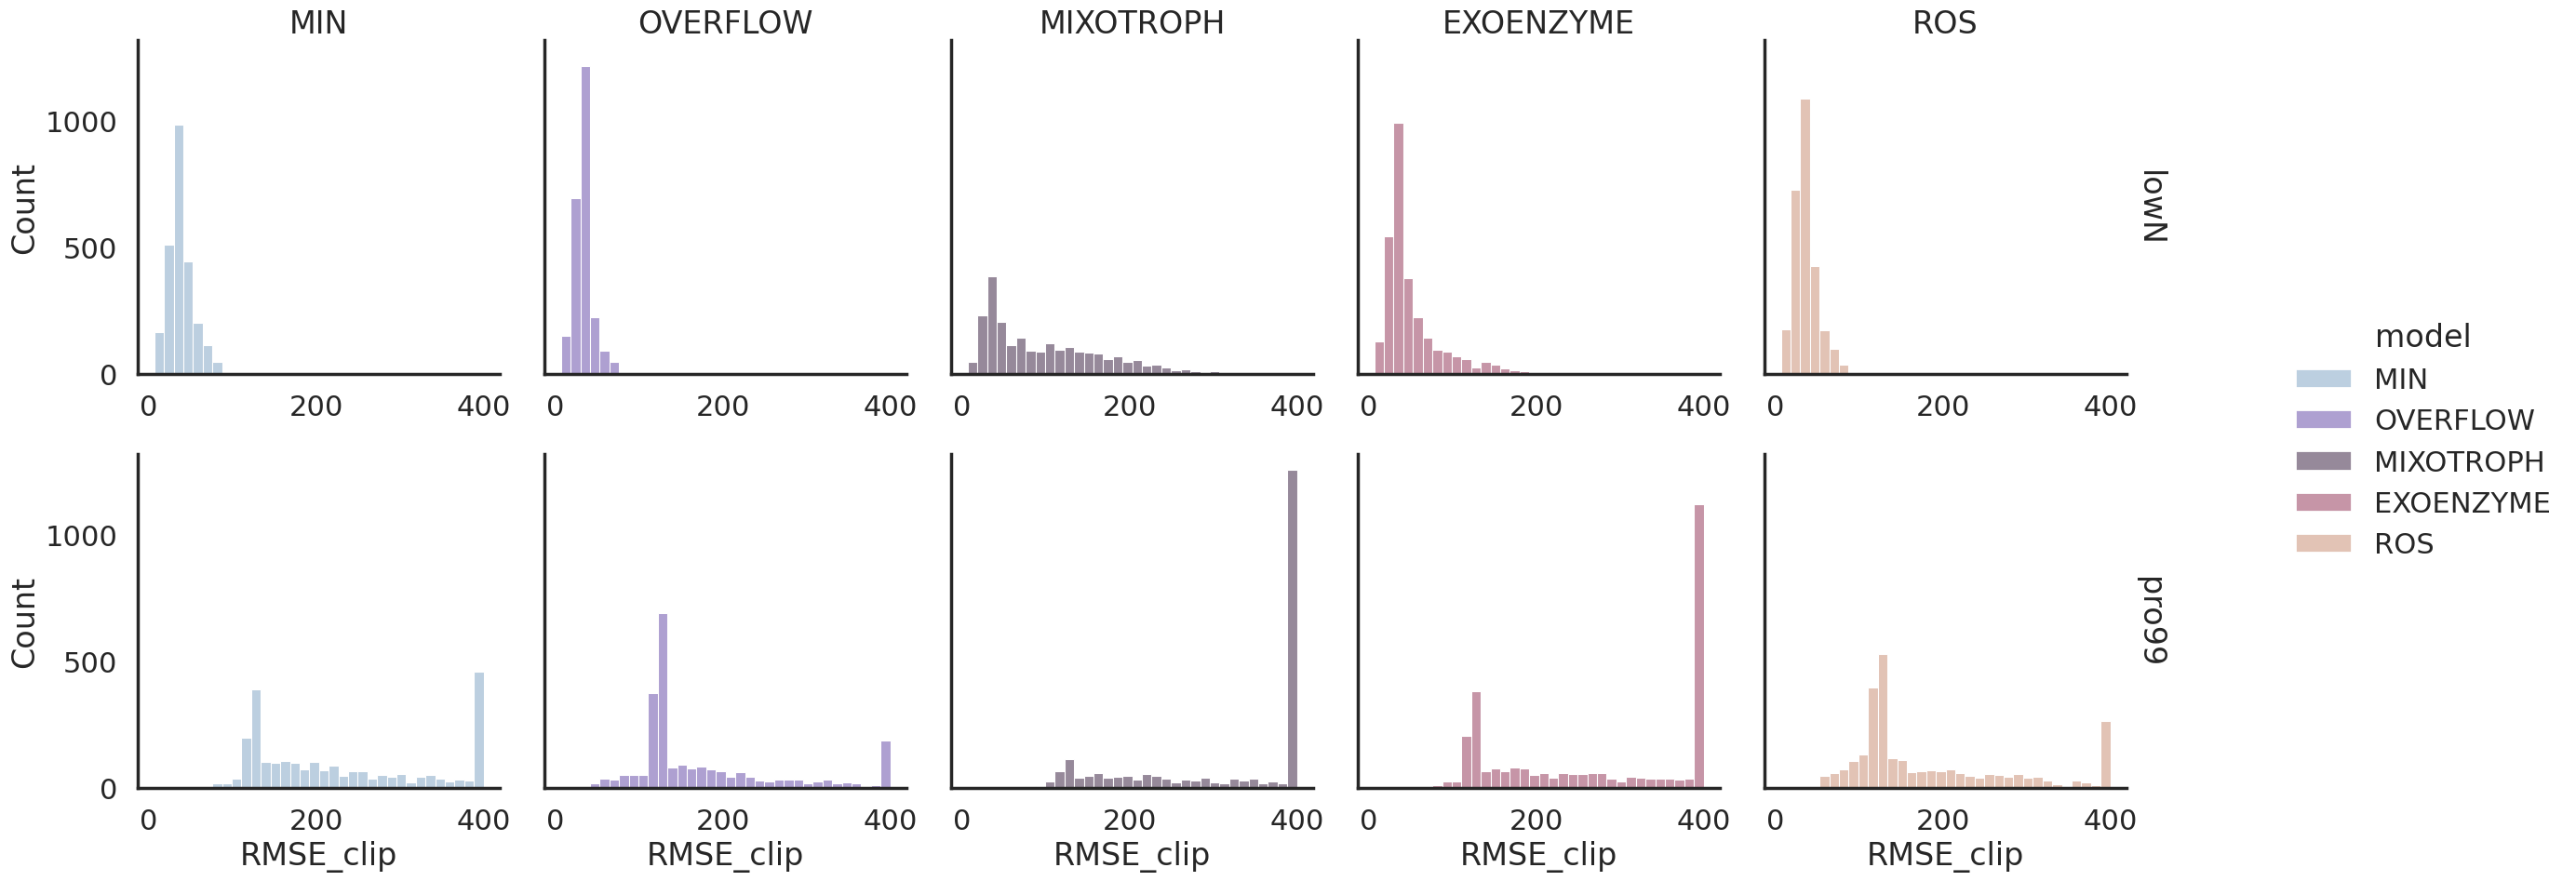

In [24]:
sns.displot(
    data=mse_df, x='RMSE_clip',
    col='model', row='media', col_order=morder,
    hue='model', palette=mpalette, hue_order=morder,
    facet_kws=dict(sharex=False, margin_titles=True),
).set_titles(col_template='{col_name}', row_template='{row_name}')

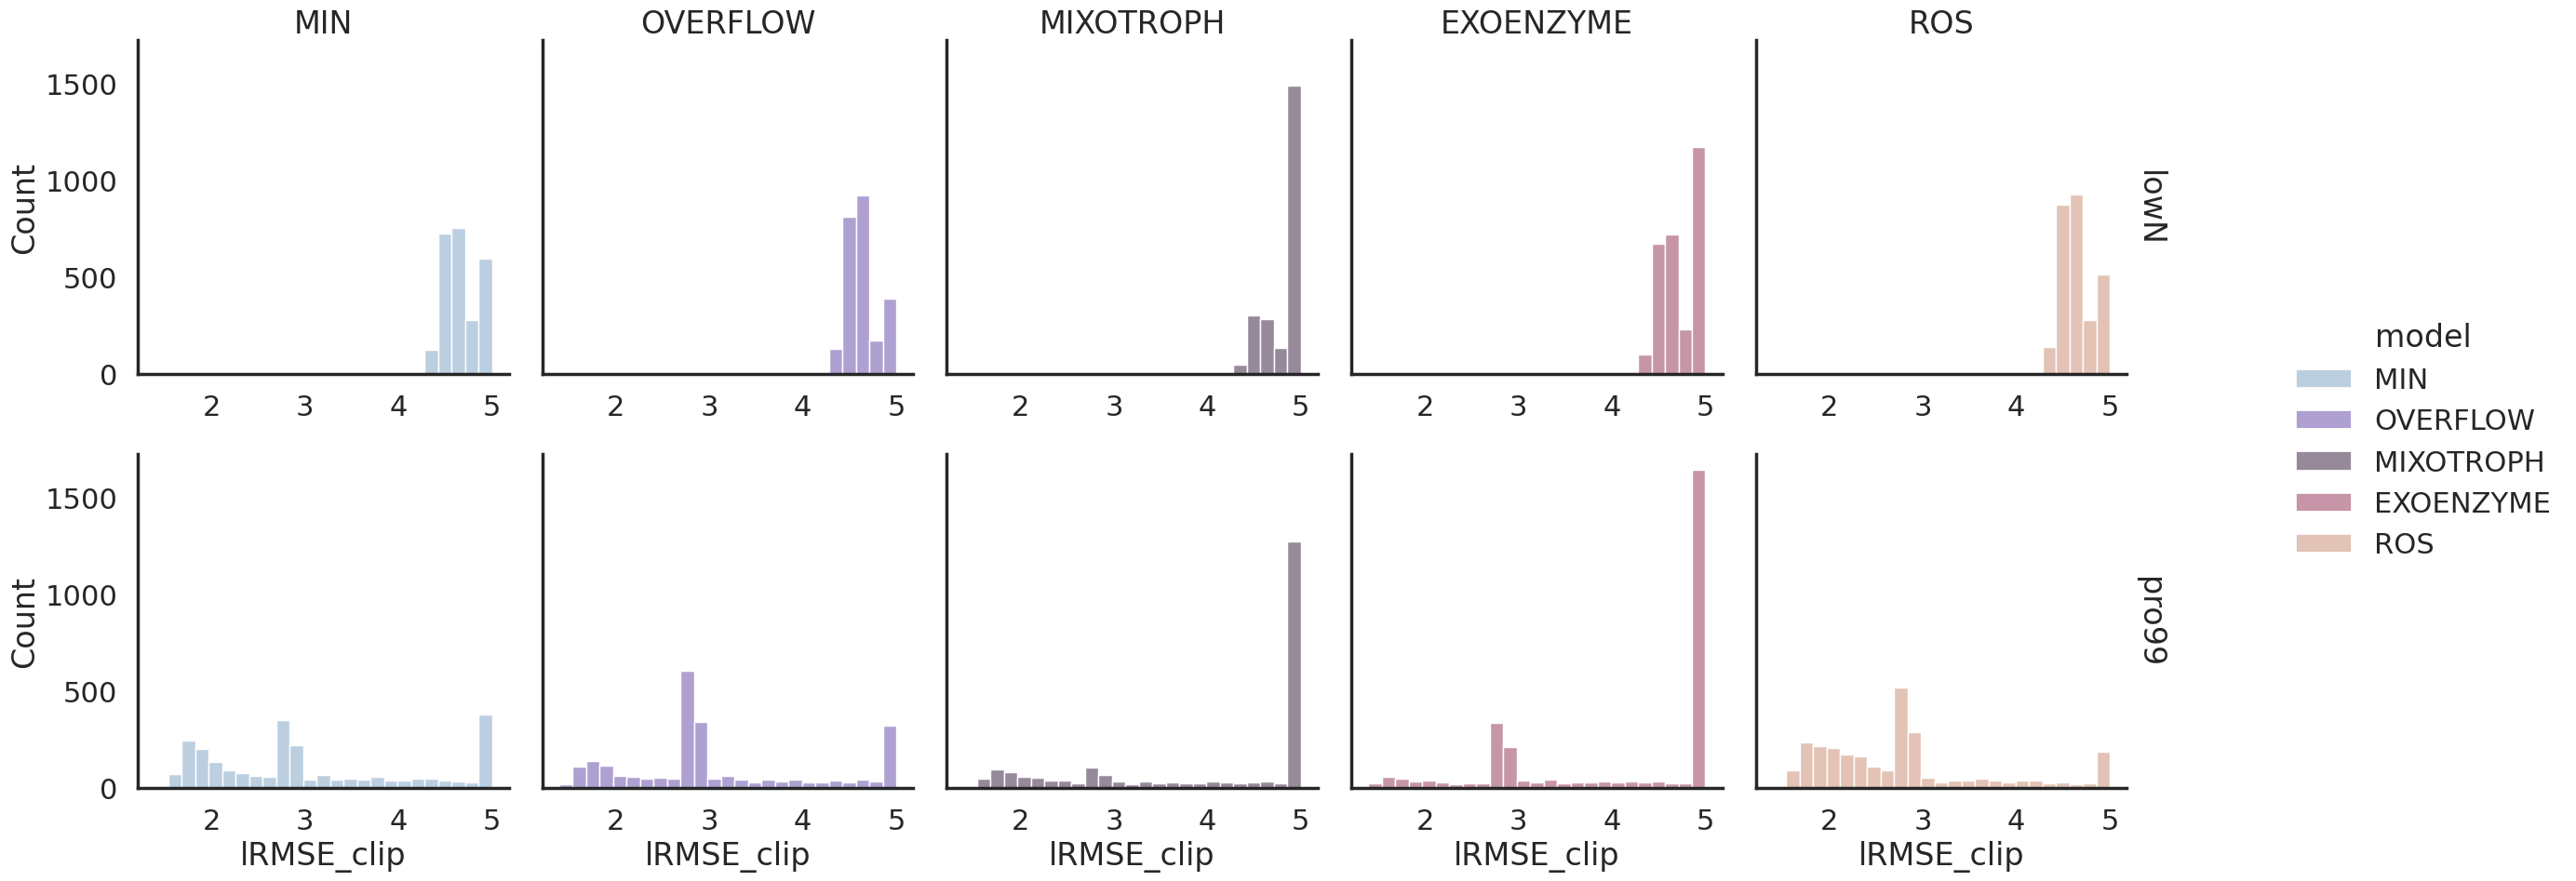

In [25]:
sns.displot(
    data=mse_df, x='lRMSE_clip',
    col='model', row='media', col_order=morder,
    hue='model', palette=mpalette, hue_order=morder,
    facet_kws=dict(sharex=False, margin_titles=True),
).set_titles(col_template='{col_name}', row_template='{row_name}')

In [26]:
sum_df['model'].value_counts()

EXOENZYME    1926
ROS          1818
MIN          1648
OVERFLOW     1611
MIXOTROPH    1500
Name: model, dtype: int64

In [27]:
mean_scores = mse_df.groupby(['model', 'idx'], as_index=False)[['RMSE_clip', 'lRMSE_clip']].mean()

In [28]:
mean_scores.groupby('model').describe()

RMSE_clip                                                            \
              count        mean        std        min         25%         50%   
model                                                                           
EXOENZYME     963.0  163.066051  71.268435  38.945322   86.893760  160.539787   
MIN           824.0  135.222571  59.327680  41.650530   77.012578  117.306429   
MIXOTROPH     751.0  207.239361  80.339204  49.186473  128.475722  235.404209   
OVERFLOW      806.0  104.789135  49.875824  32.148960   76.733385   77.365043   
ROS           909.0  110.713297  54.672837  33.490026   76.020491   82.400195   

                                  lRMSE_clip                                \
                  75%         max      count      mean       std       min   
model                                                                        
EXOENZYME  228.657451  315.287149      963.0  4.427170  0.650401  2.954203   
MIN        189.798985  246.954470      824.0  3.880080  0.646476  3.045661   
MIXOTROPH  270.122520  351.622877      751.0  4.463915  0.707659  2.994391   
OVERFLOW   122.298738  237.129343      806.0  3.861135  0.590518  2.975108   
ROS        141.655812  243.986937      909.0  3.711708  0.525005  2.992469   

                                              
                25%       50%       75%  max  
model                                         
EXOENZYME  3.682289  4.786028  5.000000  5.0  
MIN        3.345989  3.682289  4.427829  5.0  
MIXOTROPH  3.682289  5.000000  5.000000  5.0  
OVERFLOW   3.515693  3.682289  4.157088  5.0  
ROS        3.326418  3.682289  3.810822  5.0

In [29]:
mean_scores.describe()

RMSE_clip   lRMSE_clip
count  4253.000000  4253.000000
mean    143.237995     4.067475
std      73.549419     0.699147
min      32.148960     2.954203
25%      76.738647     3.510690
50%     116.878269     3.716362
75%     219.536733     4.938038
max     351.622877     5.000000

In [30]:
mean_scores.loc[mean_scores.RMSE_clip < 400, 'error_bin'] = '200-350'
mean_scores.loc[mean_scores.RMSE_clip < 200, 'error_bin'] = '100-200'
mean_scores.loc[mean_scores.RMSE_clip < 100, 'error_bin'] = '75-100'
mean_scores.loc[mean_scores.RMSE_clip < 75, 'error_bin'] = '30-75'

In [31]:
sum_df.columns

Index(['Mh', 'Mp', 'gammaDp', 'gammaDh', 'Rp', 'Rh', 'E_leakp', 'E_leakh',
       'KONp', 'KINp', 'KOCp', 'KICp', 'KONh', 'KINh', 'KOCh', 'KICh',
       'VmaxONp', 'VmaxINp', 'VmaxOCp', 'VmaxICp', 'VmaxONh', 'VmaxINh',
       'VmaxOCh', 'VmaxICh', 'OverflowMode', 'E_ROSp', 'E_ROSh', 'VmaxROSh',
       'K_ROSh', 'ROS_decay', 'KABp', 'KABh', 'EABp', 'EABh', 'decayABh',
       'decayABp', 'MABp', 'MABh', 'r0p', 'r0h', 'bp', 'bh', 'QNmaxp',
       'QNminp', 'QNmaxh', 'QNminh', 'Kmtbp', 'Kmtbh', 'gamma_DON2DINp',
       'gamma_DON2DINh', 'QCmaxp', 'QCminp', 'QCmaxh', 'QCminh', 'ROSMode',
       'omegaP', 'omegaH', 'run_id', 'id', 'media', 'which', 'model', 'hash',
       'idx'],
      dtype='object')

In [32]:
id_vars= ['model', 'idx']
sum_df1 = sum_df.drop_duplicates(subset='idx')
def _get_params_df(model):
    params_to_update, bounds, log_params = get_param_tuning_values(model, organism_to_tune)
    param_vals = sum_df1.loc[sum_df1.model.isin([model]), id_vars + params_to_update]
    mparam_vals = param_vals.melt( id_vars=id_vars)    
    return mparam_vals
mparams_df = pd.concat([_get_params_df(model) for model in morder], ignore_index=True)


In [33]:
mparams_df = pd.merge(mean_scores, mparams_df, how='left', on=id_vars )

In [34]:
mparams_df.variable.unique()

array(['Mp', 'gammaDp', 'E_leakp', 'KINp', 'KICp', 'VmaxINp', 'VmaxICp',
       'gamma_DON2DINp', 'KONp', 'KOCp', 'VmaxONp', 'VmaxOCp', nan,
       'E_ROSp', 'omegaP'], dtype=object)

In [35]:
mparams_df.loc[mparams_df.variable.isna()]

model                        idx   RMSE_clip  lRMSE_clip error_bin  \
21458  MIXOTROPH  shgo2_sobol_796_MIXOTROPH  108.784562         5.0   100-200   

      variable  value  
21458      NaN    NaN

In [49]:
vmaxparam_names = ['VmaxINp', 'VmaxICp','VmaxONp', 'VmaxOCp',]
kmparam_names = [ 'KINp', 'KICp',  'KONp', 'KOCp', ]
otherparam_names = ['Mp',  'E_leakp',  'gamma_DON2DINp', 'E_ROSp', 'omegaP']
param_names = ['gammaDp', ]



In [40]:
mparams_df.loc[mparams_df.variable.isin(log_param_names)]

model                      idx   RMSE_clip  lRMSE_clip error_bin  \
0      EXOENZYME  shgo2_sobol_0_EXOENZYME  213.280300    4.775184   200-350   
2      EXOENZYME  shgo2_sobol_0_EXOENZYME  213.280300    4.775184   200-350   
5      EXOENZYME  shgo2_sobol_0_EXOENZYME  213.280300    4.775184   200-350   
6      EXOENZYME  shgo2_sobol_0_EXOENZYME  213.280300    4.775184   200-350   
7      EXOENZYME  shgo2_sobol_0_EXOENZYME  213.280300    4.775184   200-350   
...          ...                      ...         ...         ...       ...   
35539        ROS        shgo2_sobol_9_ROS   71.677075    3.330408     30-75   
35542        ROS        shgo2_sobol_9_ROS   71.677075    3.330408     30-75   
35543        ROS        shgo2_sobol_9_ROS   71.677075    3.330408     30-75   
35544        ROS        shgo2_sobol_9_ROS   71.677075    3.330408     30-75   
35545        ROS        shgo2_sobol_9_ROS   71.677075    3.330408     30-75   

             variable         value  
0                  Mp  7.169699e-07  
2             E_leakp  1.704407e-06  
5             VmaxINp  5.258268e-05  
6             VmaxICp  2.088305e-04  
7      gamma_DON2DINp  1.225151e-08  
...               ...           ...  
35539         E_leakp  3.329124e-07  
35542         VmaxINp  8.133317e-05  
35543         VmaxICp  9.886820e-05  
35544          E_ROSp  5.126225e-06  
35545          omegaP  7.520030e-03  

[21289 rows x 7 columns]

In [51]:
mean_scores['rank'] = mean_scores.groupby("model")["RMSE_clip"].transform("rank")
mean_scores['lrank'] = mean_scores.groupby("model")["lRMSE_clip"].transform("rank")


In [52]:
min_rows = mean_scores.loc[mean_scores['rank'].le(50)]
lmin_rows = mean_scores.loc[mean_scores['lrank'].le(50)]
min_rows

model                        idx  RMSE_clip  lRMSE_clip error_bin  \
75    EXOENZYME  shgo2_sobol_153_EXOENZYME  76.227931    3.708786    75-100   
92    EXOENZYME  shgo2_sobol_169_EXOENZYME  70.357131    3.329045     30-75   
101   EXOENZYME  shgo2_sobol_177_EXOENZYME  52.398163    3.028114     30-75   
104   EXOENZYME   shgo2_sobol_17_EXOENZYME  72.933017    3.202791     30-75   
127   EXOENZYME  shgo2_sobol_201_EXOENZYME  55.500561    2.981044     30-75   
...         ...                        ...        ...         ...       ...   
4154        ROS        shgo2_sobol_898_ROS  50.788506    3.168520     30-75   
4167        ROS        shgo2_sobol_909_ROS  53.636532    3.409123     30-75   
4171        ROS        shgo2_sobol_912_ROS  50.386583    3.130147     30-75   
4221        ROS        shgo2_sobol_965_ROS  50.877197    3.053161     30-75   
4240        ROS        shgo2_sobol_986_ROS  48.261150    3.124815     30-75   

      rank  lrank  
75    44.0  273.0  
92    29.0   71.0  
101    4.0   13.0  
104   34.0   45.0  
127    9.0    3.0  
...    ...    ...  
4154  41.0  101.0  
4167  50.0  294.0  
4171  39.0   82.0  
4221  42.0   17.0  
4240  33.0   75.0  

[250 rows x 7 columns]

In [57]:
refdf.columns


Index(['day', 'Sample', 'id', 'replicate', 'transfer', 'transfer day',
       'heterotroph', 'full name', 'FL', 'Group', 'predicted', 'ref_Bp[N]',
       'ref_Bp[C]', 't'],
      dtype='object')

In [78]:
len(set(min_rows.idx)), len(set(lmin_rows.idx)), len(set(min_rows.idx) | set(lmin_rows.idx)), len(set(min_rows.idx) & set(lmin_rows.idx)), 


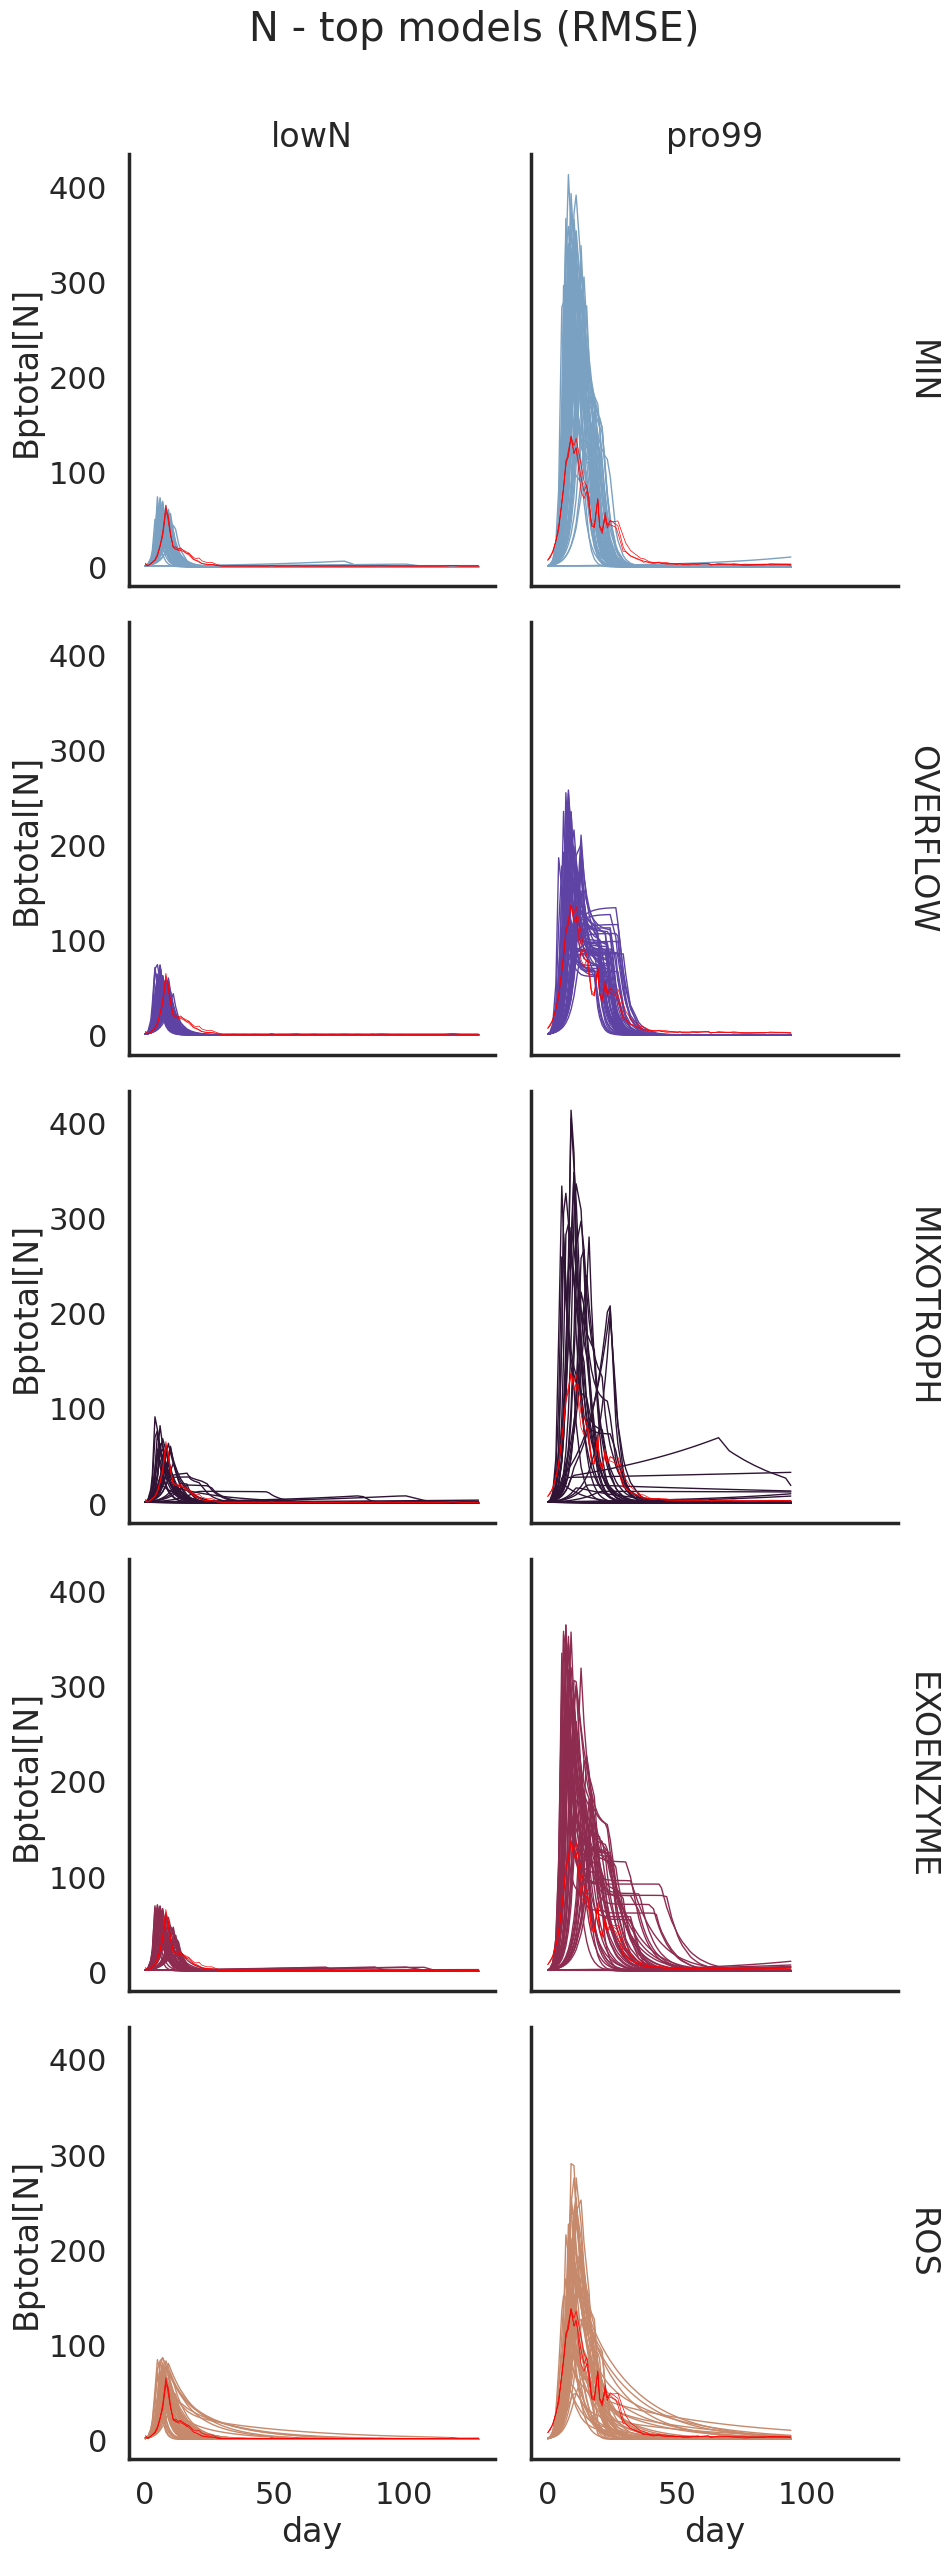

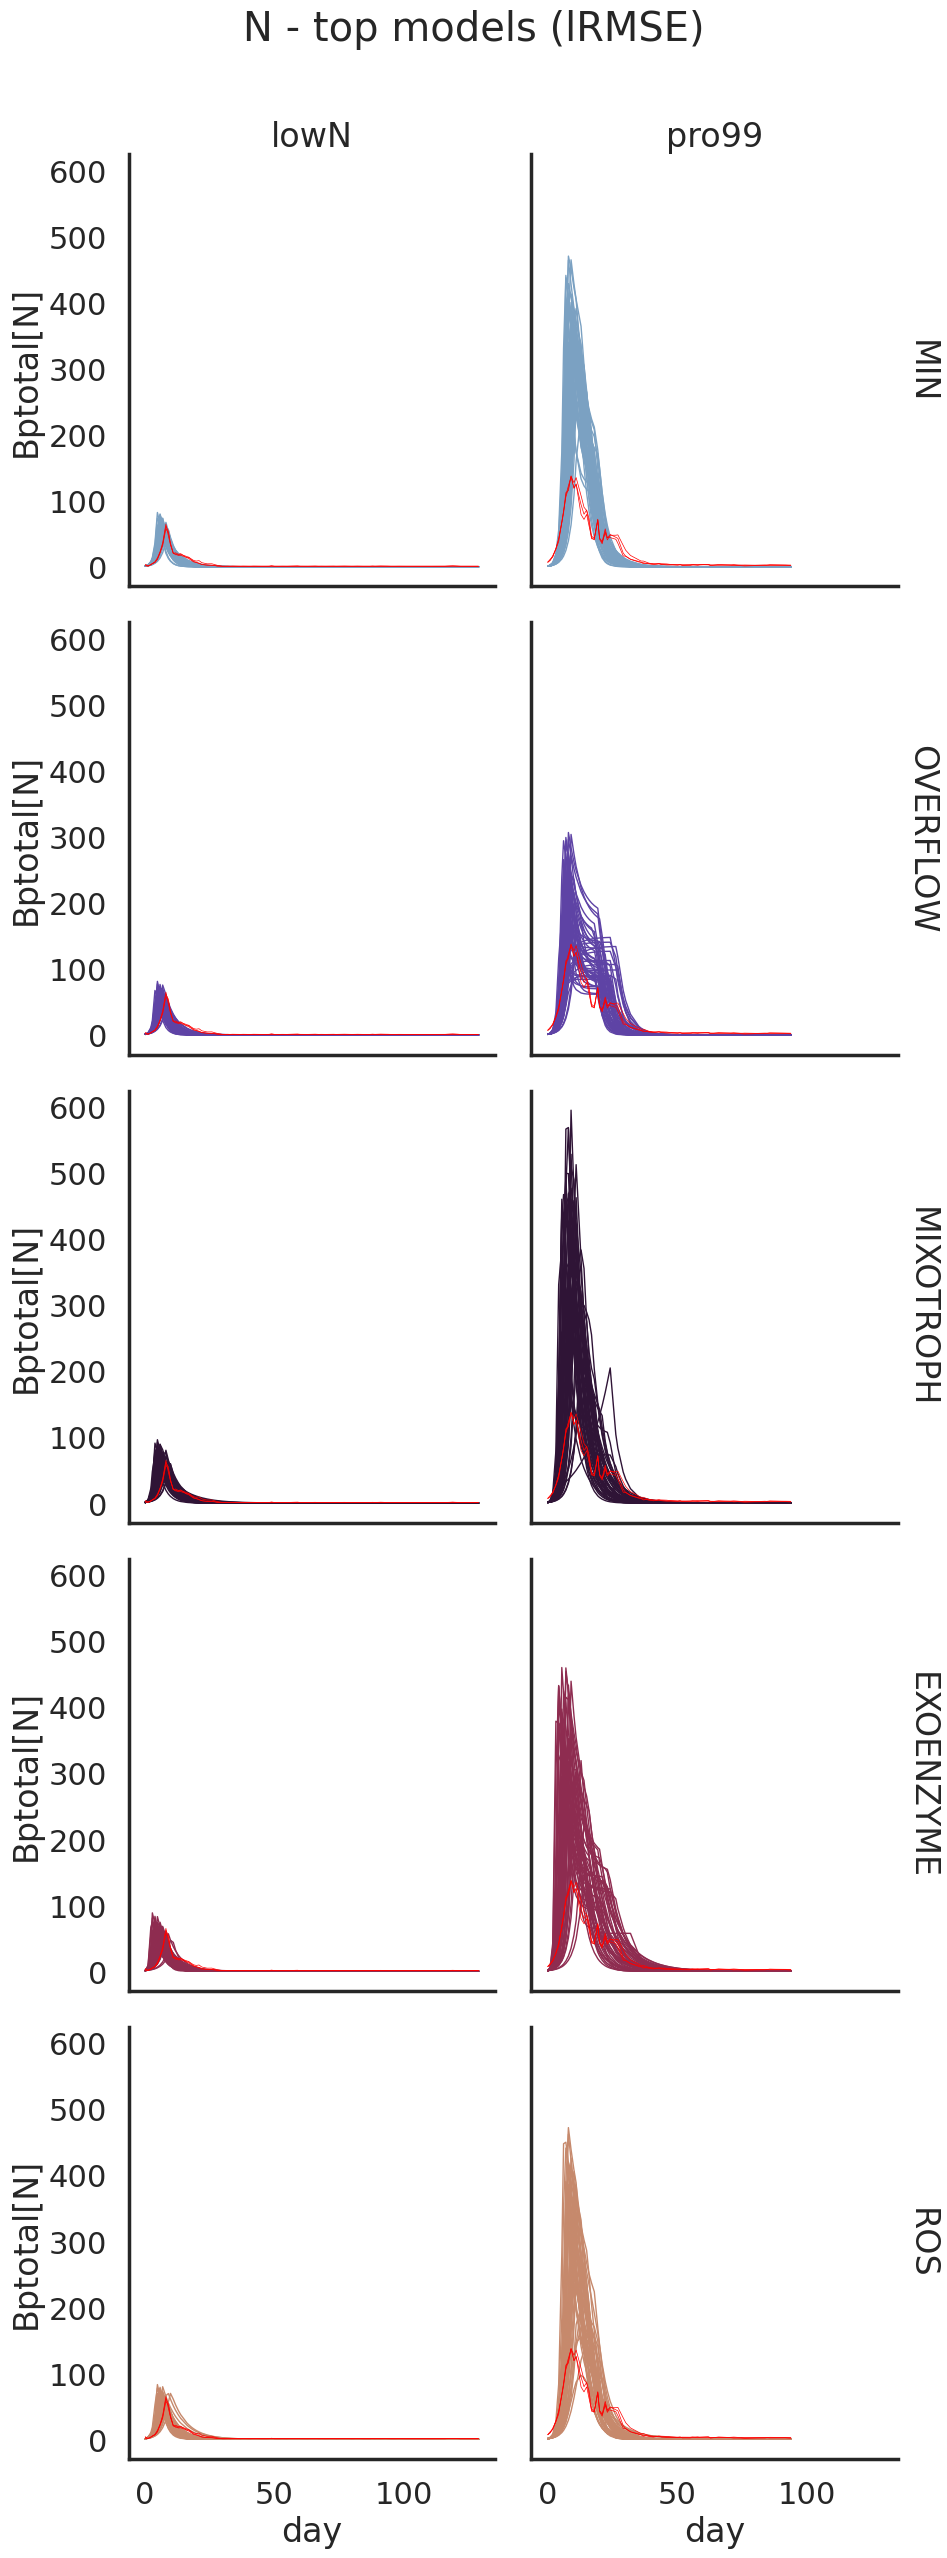

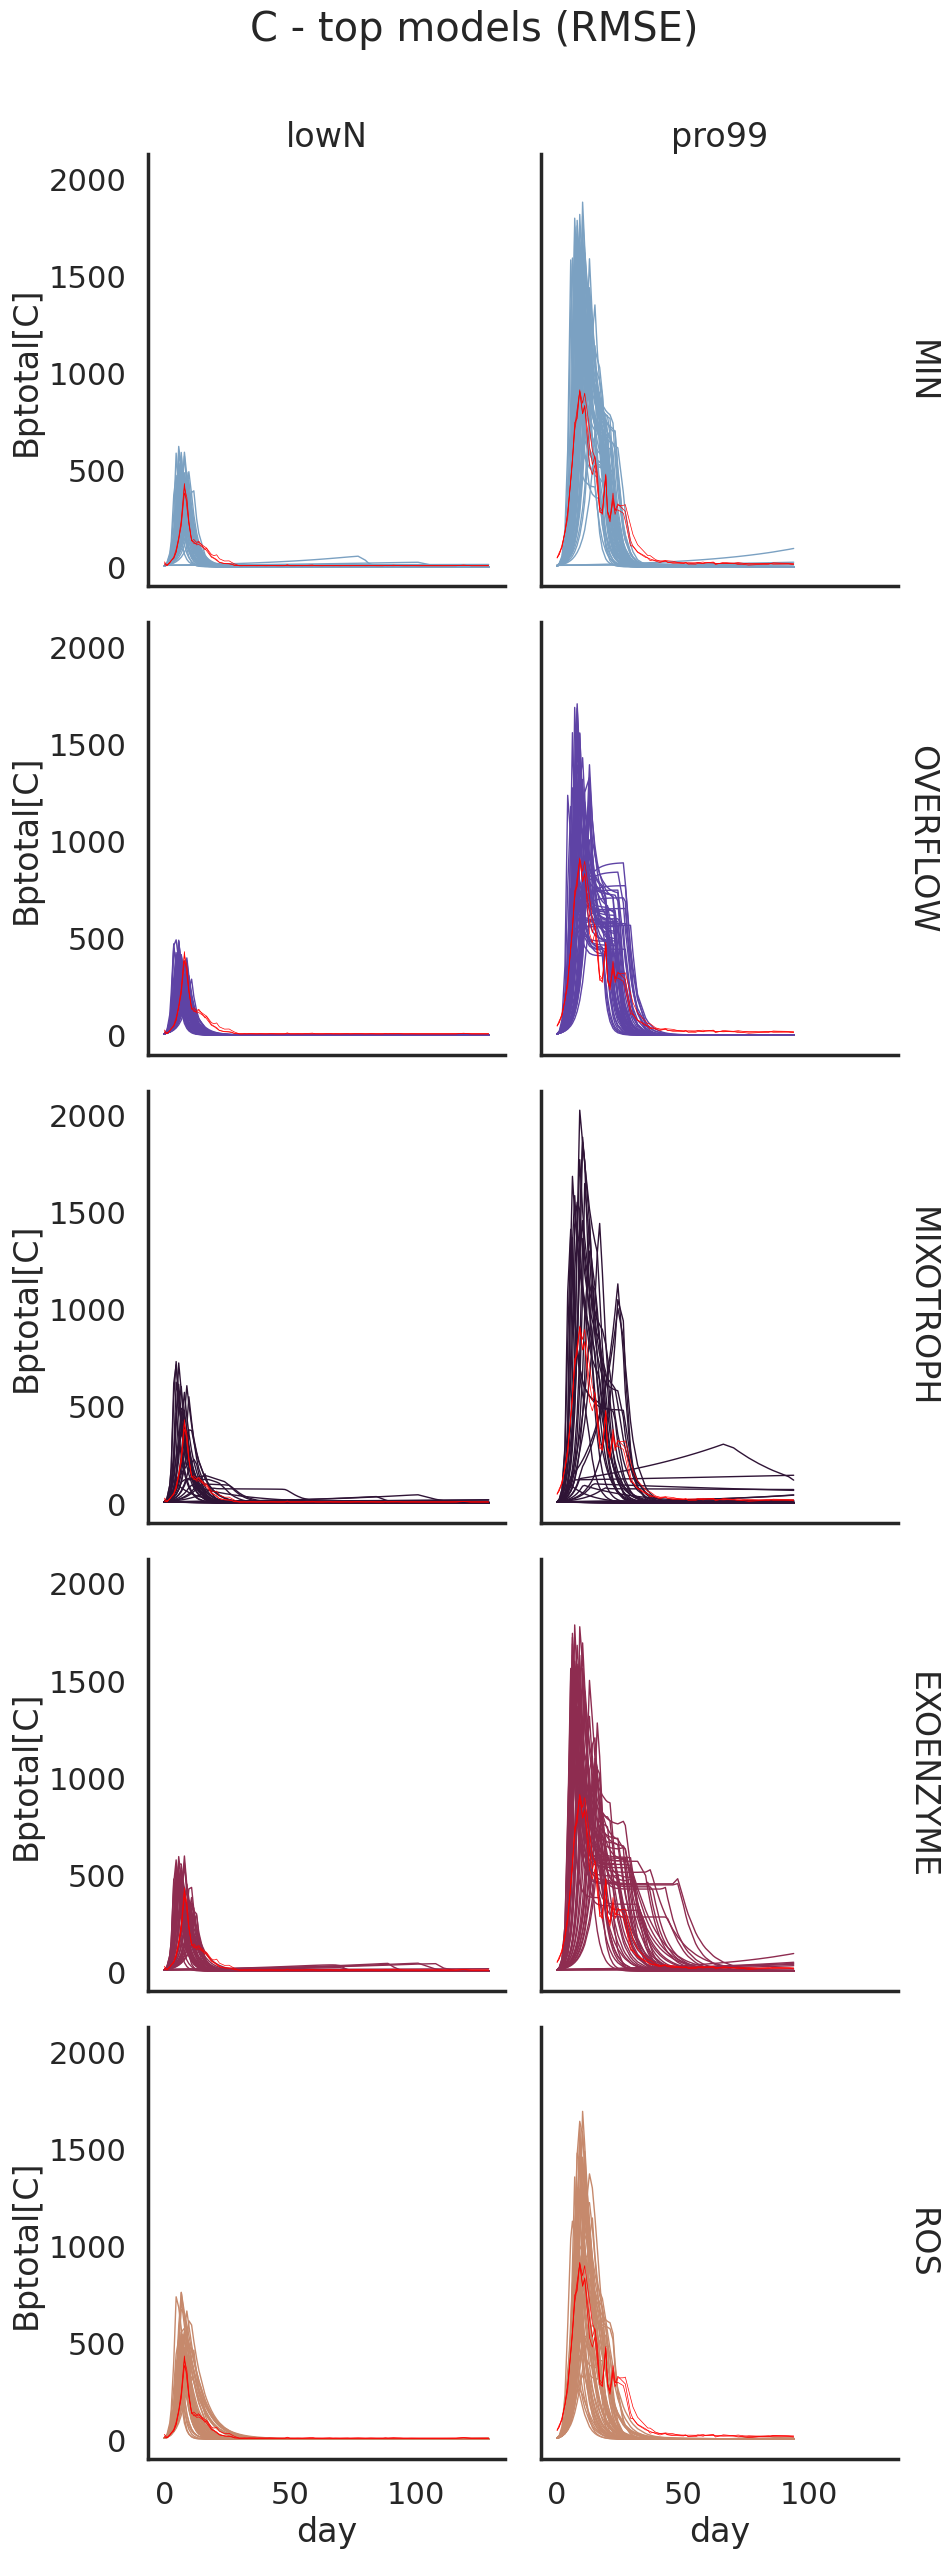

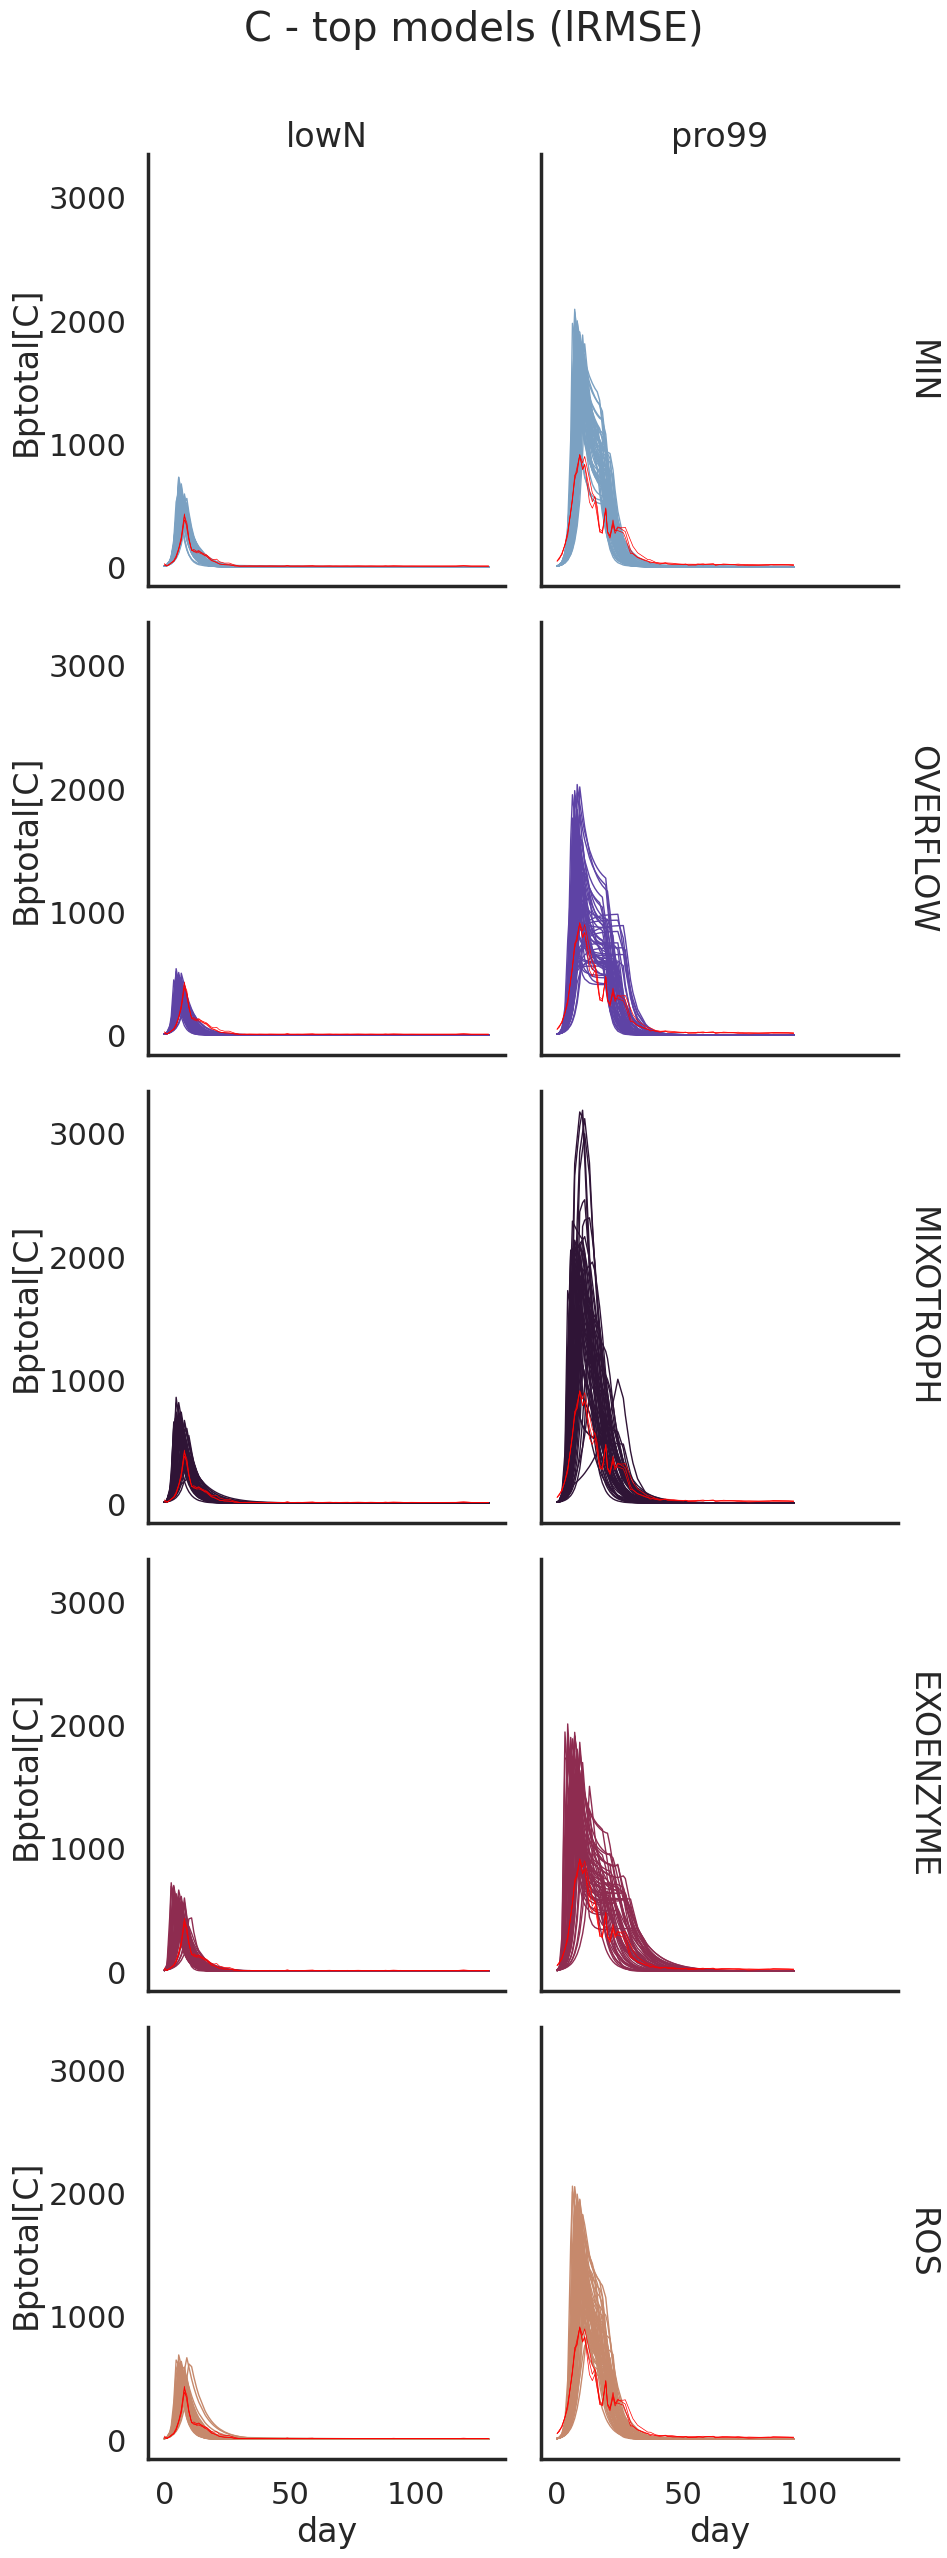

In [75]:
for n in ('N', 'C'):
    for l in ('RMSE', 'lRMSE'):
        mrows = min_rows if l == 'RMSE' else lmin_rows
        g = sns.relplot(
            data=df.loc[df.idx.isin(mrows.idx)],
            kind='line', 
            estimator=None, units='idx',
            x='day', y=f'Bptotal[{n}]', 
            col='media', col_order=media_order, lw=1,
            hue='model', hue_order=morder, palette=mpalette,
            row='model', row_order=morder, 
            facet_kws=dict( margin_titles=True),
            legend=False
        )
        for (row_val,col_val), ax in g.axes_dict.items():
            datadf = refdf if col_val == 'lowN' else refp99df
            sns.lineplot(data=datadf, x='day', y=f'ref_Bp[{n}]',
            units='Sample', estimator=None, ax=ax, lw=0.5, color='red',

                         legend=False
                        )
        g.set_titles(col_template='{col_name}', row_template='{row_name}')
        plt.suptitle(f'{n} - top models ({l})', y=1.03)

In [79]:
df.columns

Index(['Bp', 'Np', 'Cp', 'DON', 'RDON', 'DIN', 'DOC', 'RDOC', 'DIC', 'ROS',
       't', 'day', 'gross_uptakeINp', 'gross_uptakeONp', 'gross_uptakeICp',
       'gross_uptakeOCp', 'uptakeNp', 'uptakeCp', 'QCp', 'biosynthesisNp',
       'respirationCp', 'biomass_breakdownCp', 'overflowNp', 'overflowCp',
       'Bp[C]', 'Bptotal[N]', 'Bptotal[C]', 'log_Bptotal[N]', 'log_Bptotal[C]',
       'run_id', 'id', 'media', 'which', 'model', 'hash', 'idx'],
      dtype='object')

In [80]:
mdf1 = df.melt(
    id_vars=['t', 'day', 'run_id', 'id', 'media', 'which', 'model', 'hash', 'idx'], 
    value_vars=var_names)

In [92]:
mdf2 = df.melt(
    id_vars=['t', 'day', 'run_id', 'id', 'media', 'which', 'model', 'hash', 'idx'], 
    value_vars=intermediate_names)

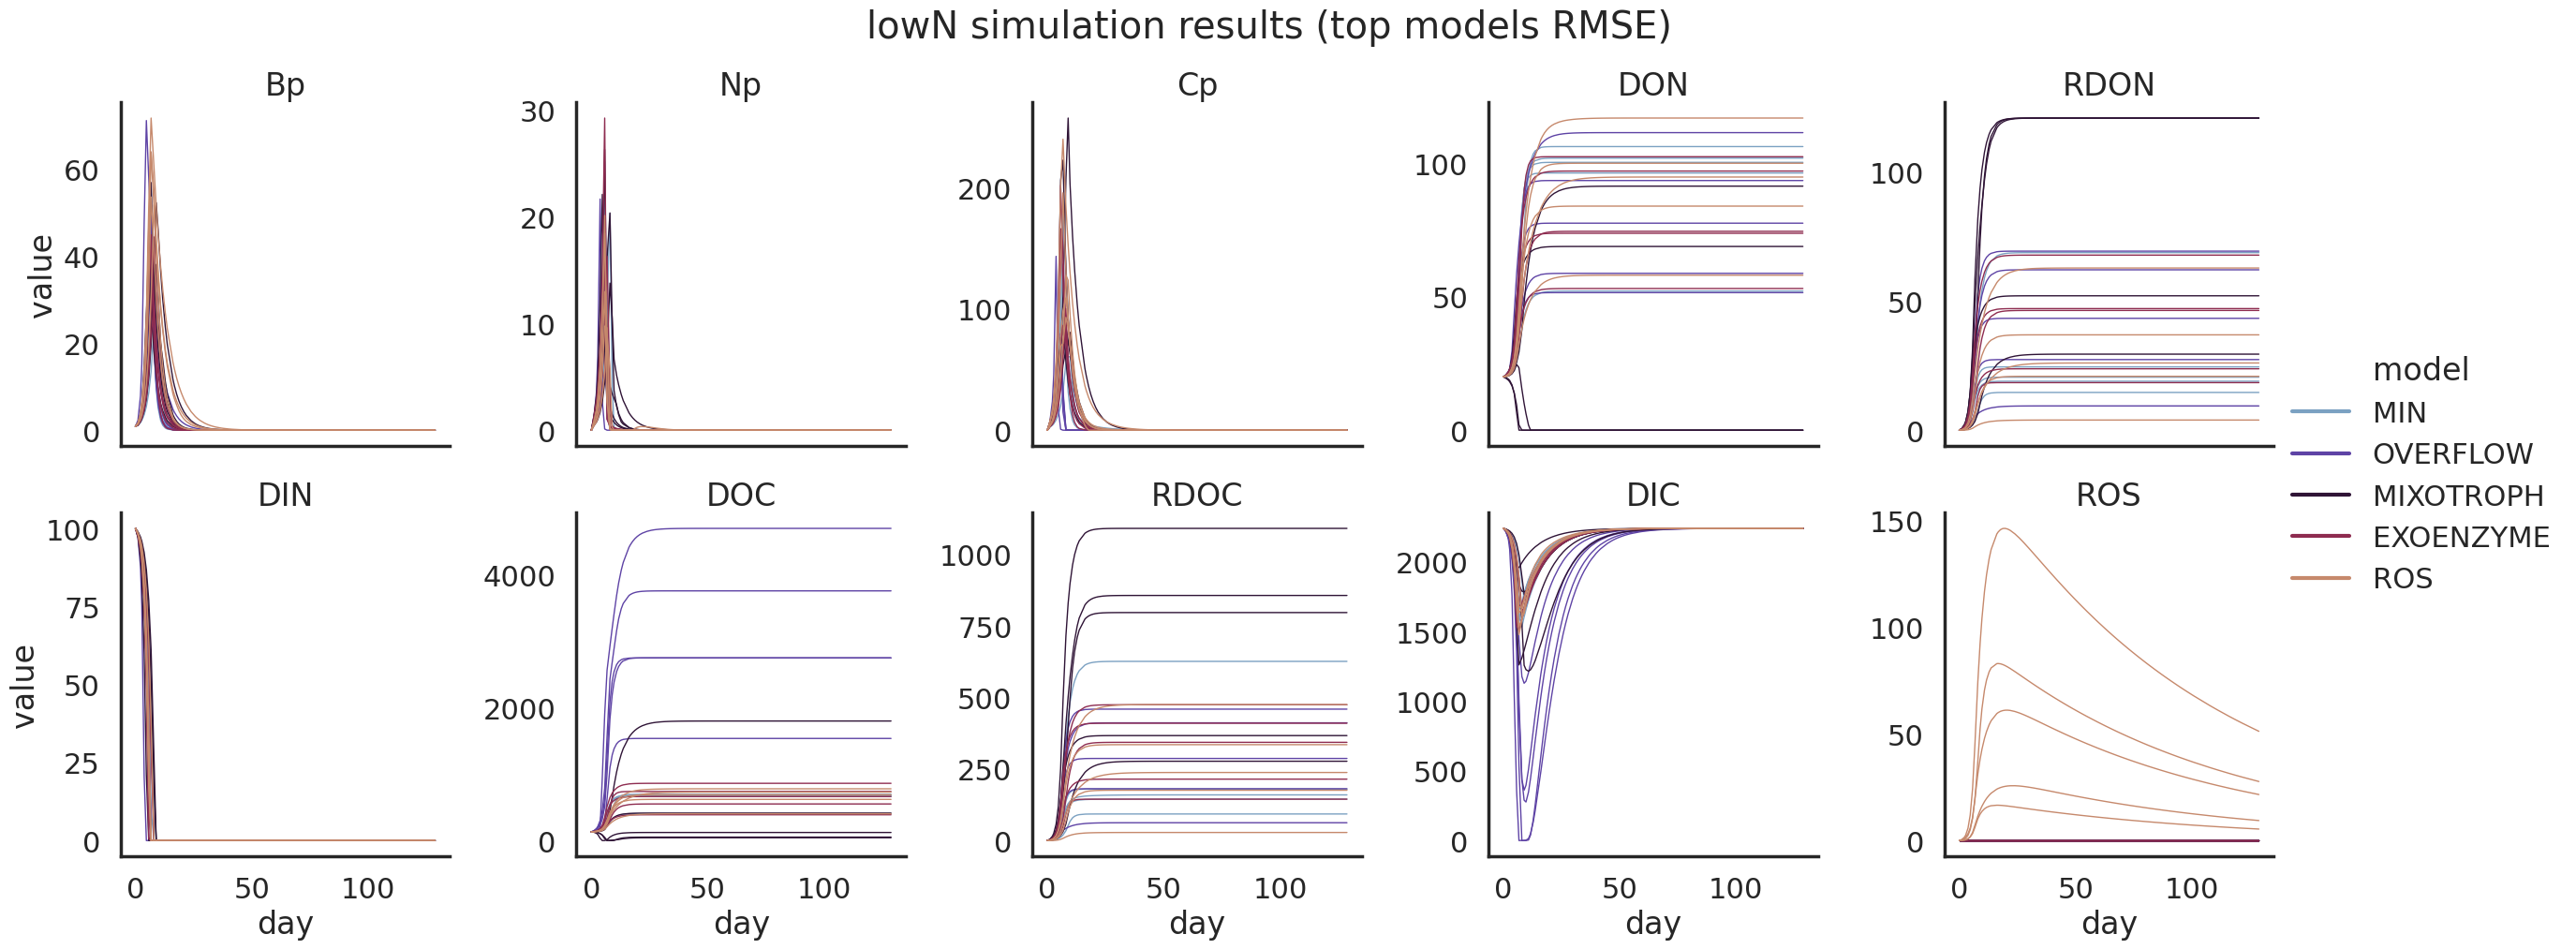

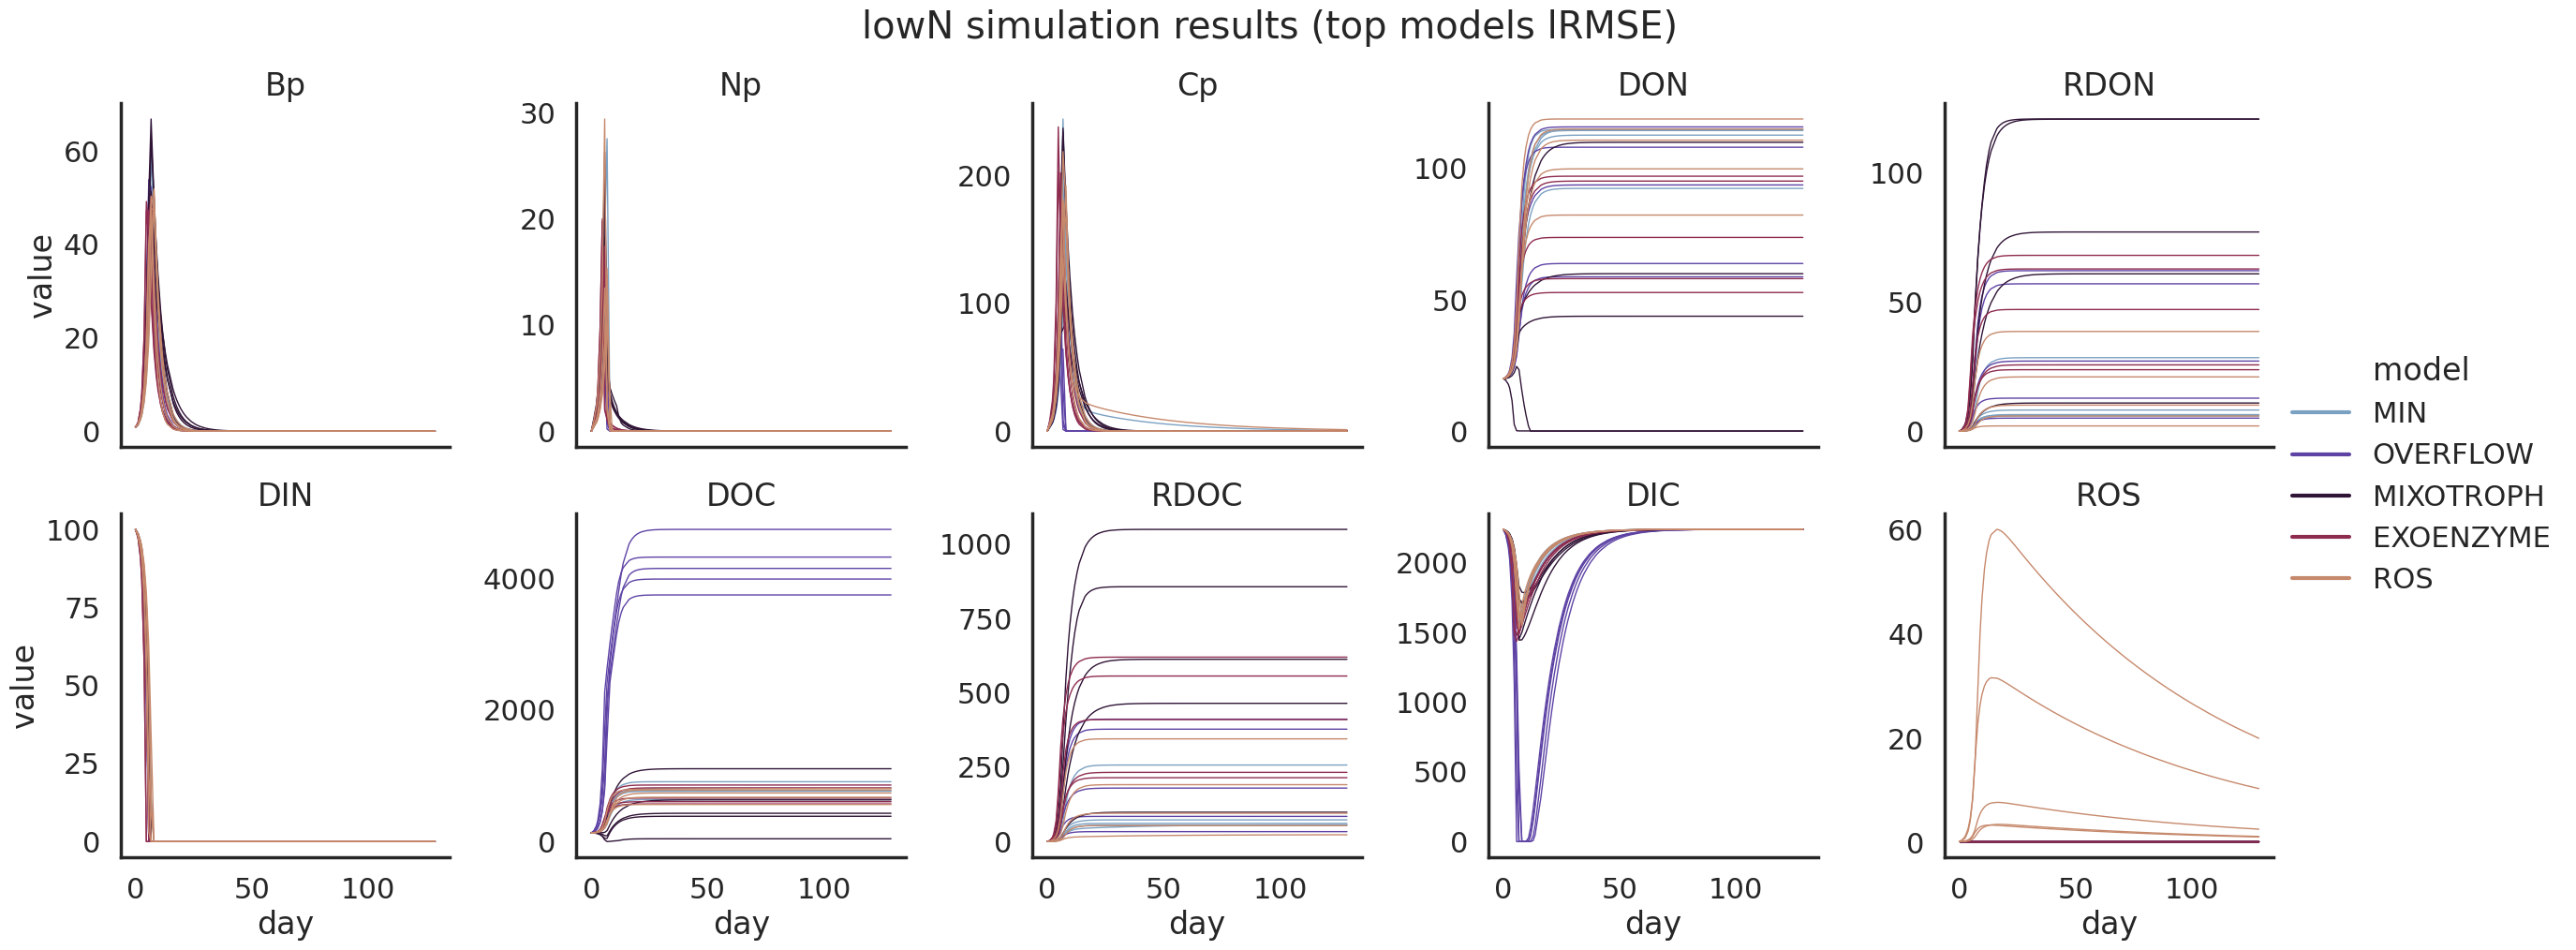

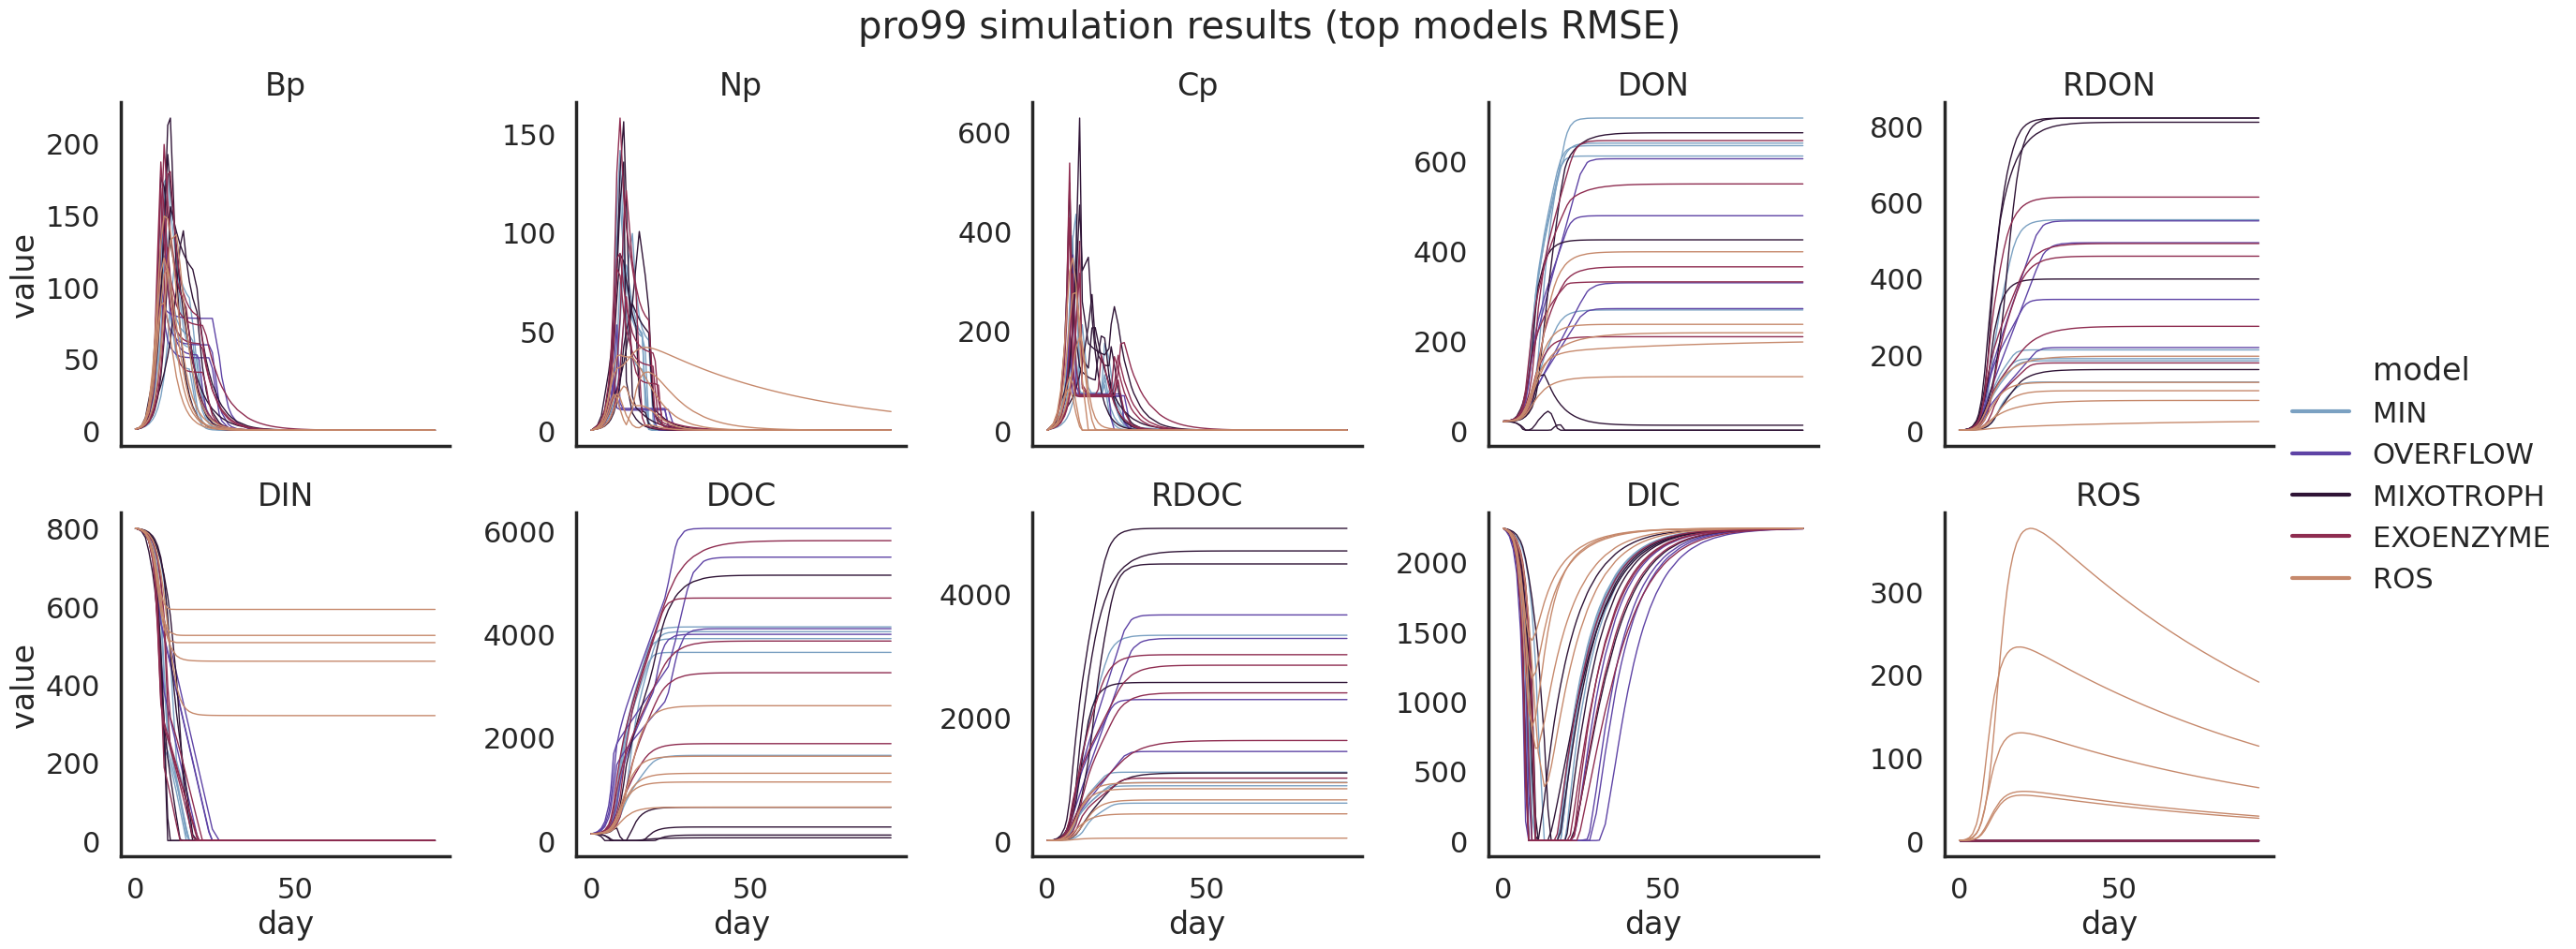

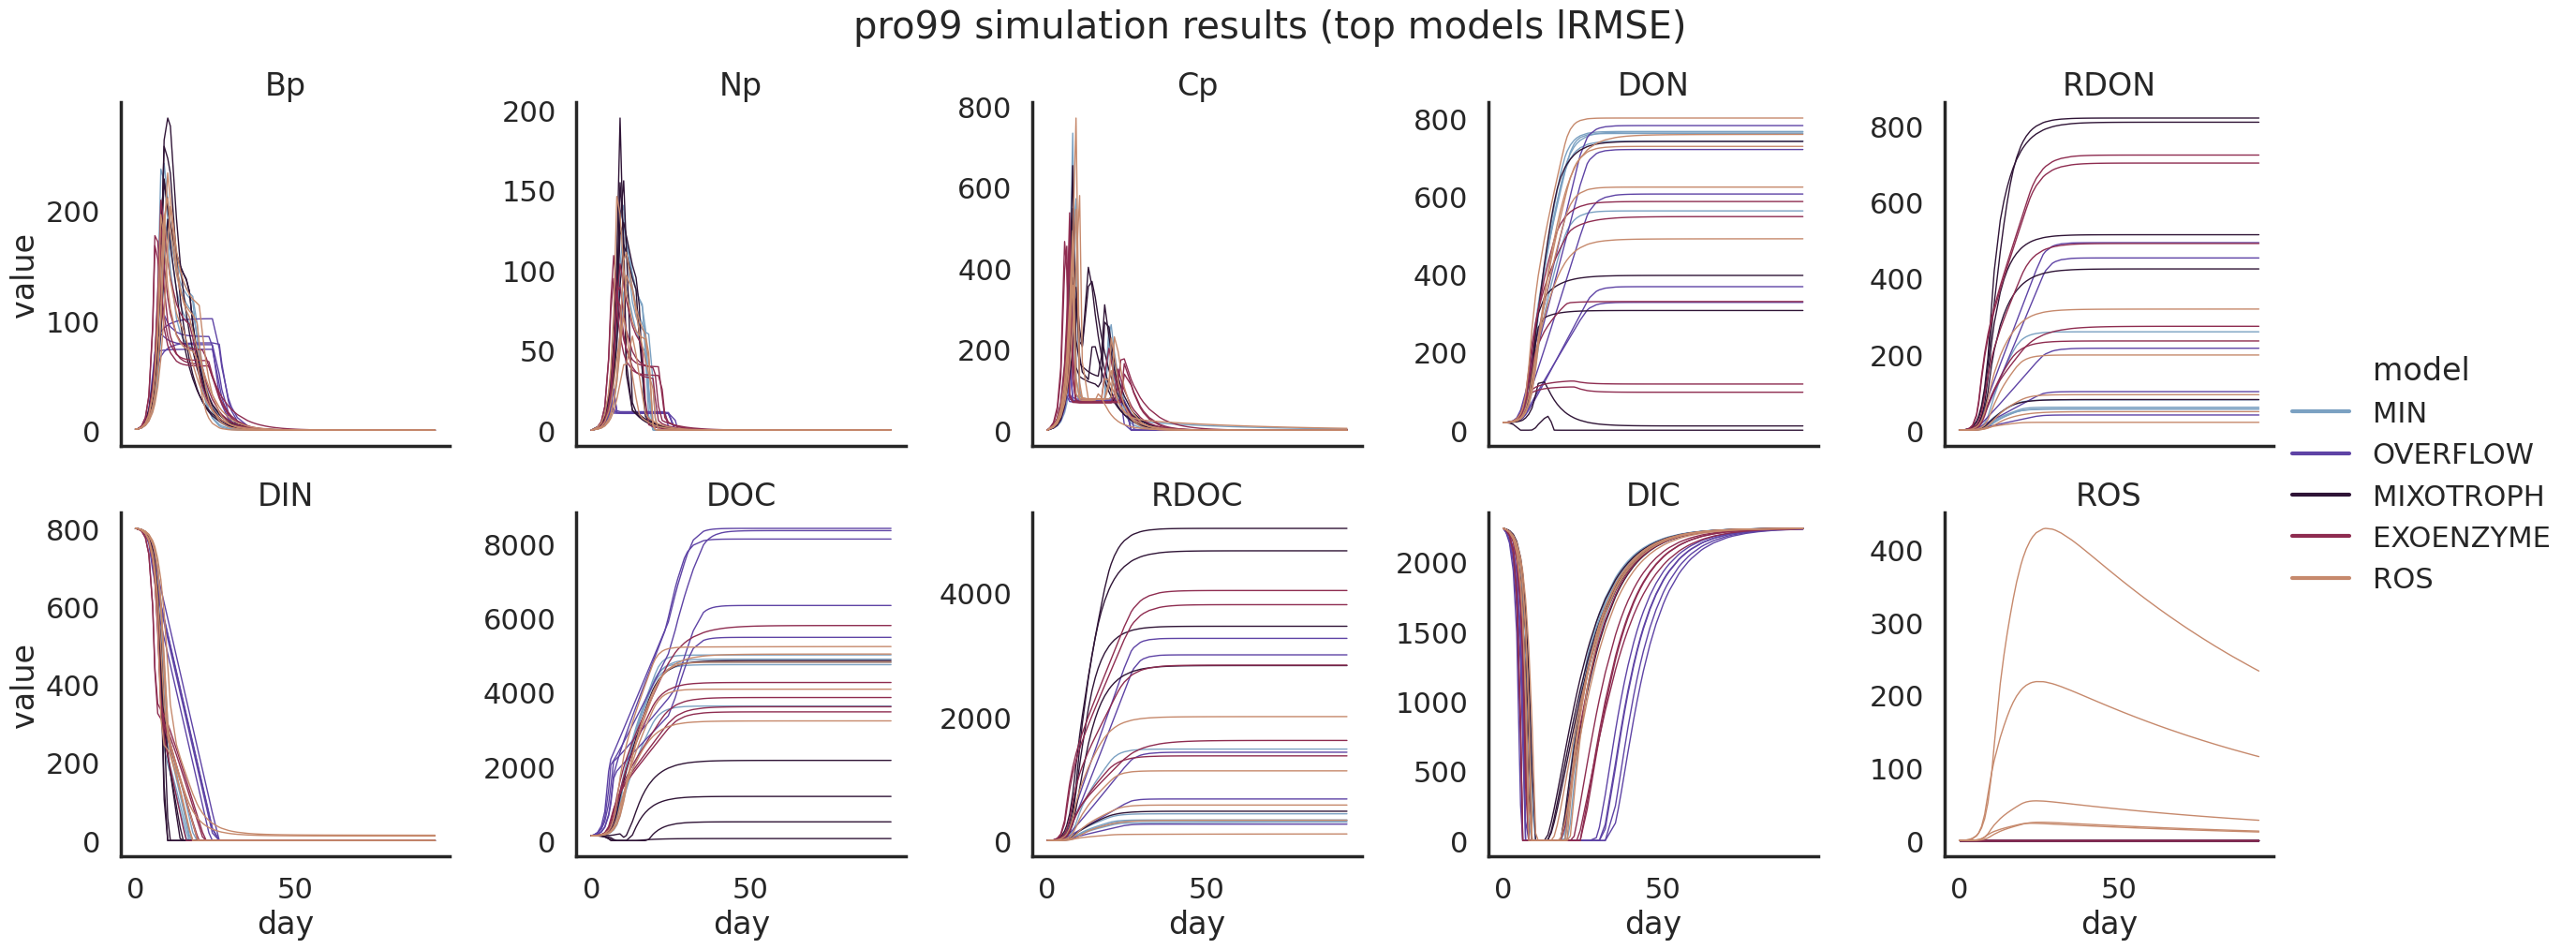

In [89]:
for med in media_order:
    for l in ('RMSE', 'lRMSE'):
        rankcol = 'rank' if l == 'RMSE' else 'lrank'
        mrows = mean_scores.loc[mean_scores[rankcol].le(5)]

        g = sns.relplot(
            data=mdf1.loc[mdf1.idx.isin(mrows.idx) & mdf1.media.isin([med])],
            kind='line', 
            estimator=None, units='idx',
            x='day', y='value', 
            col='variable', lw=1, col_wrap=5,
            hue='model', hue_order=morder, palette=mpalette,
            facet_kws=dict( margin_titles=True, sharey=False),

        )
        g.set_titles(col_template='{col_name}', row_template='{row_name}')
        plt.suptitle(f'{med} simulation results (top models {l})', y=1.03)

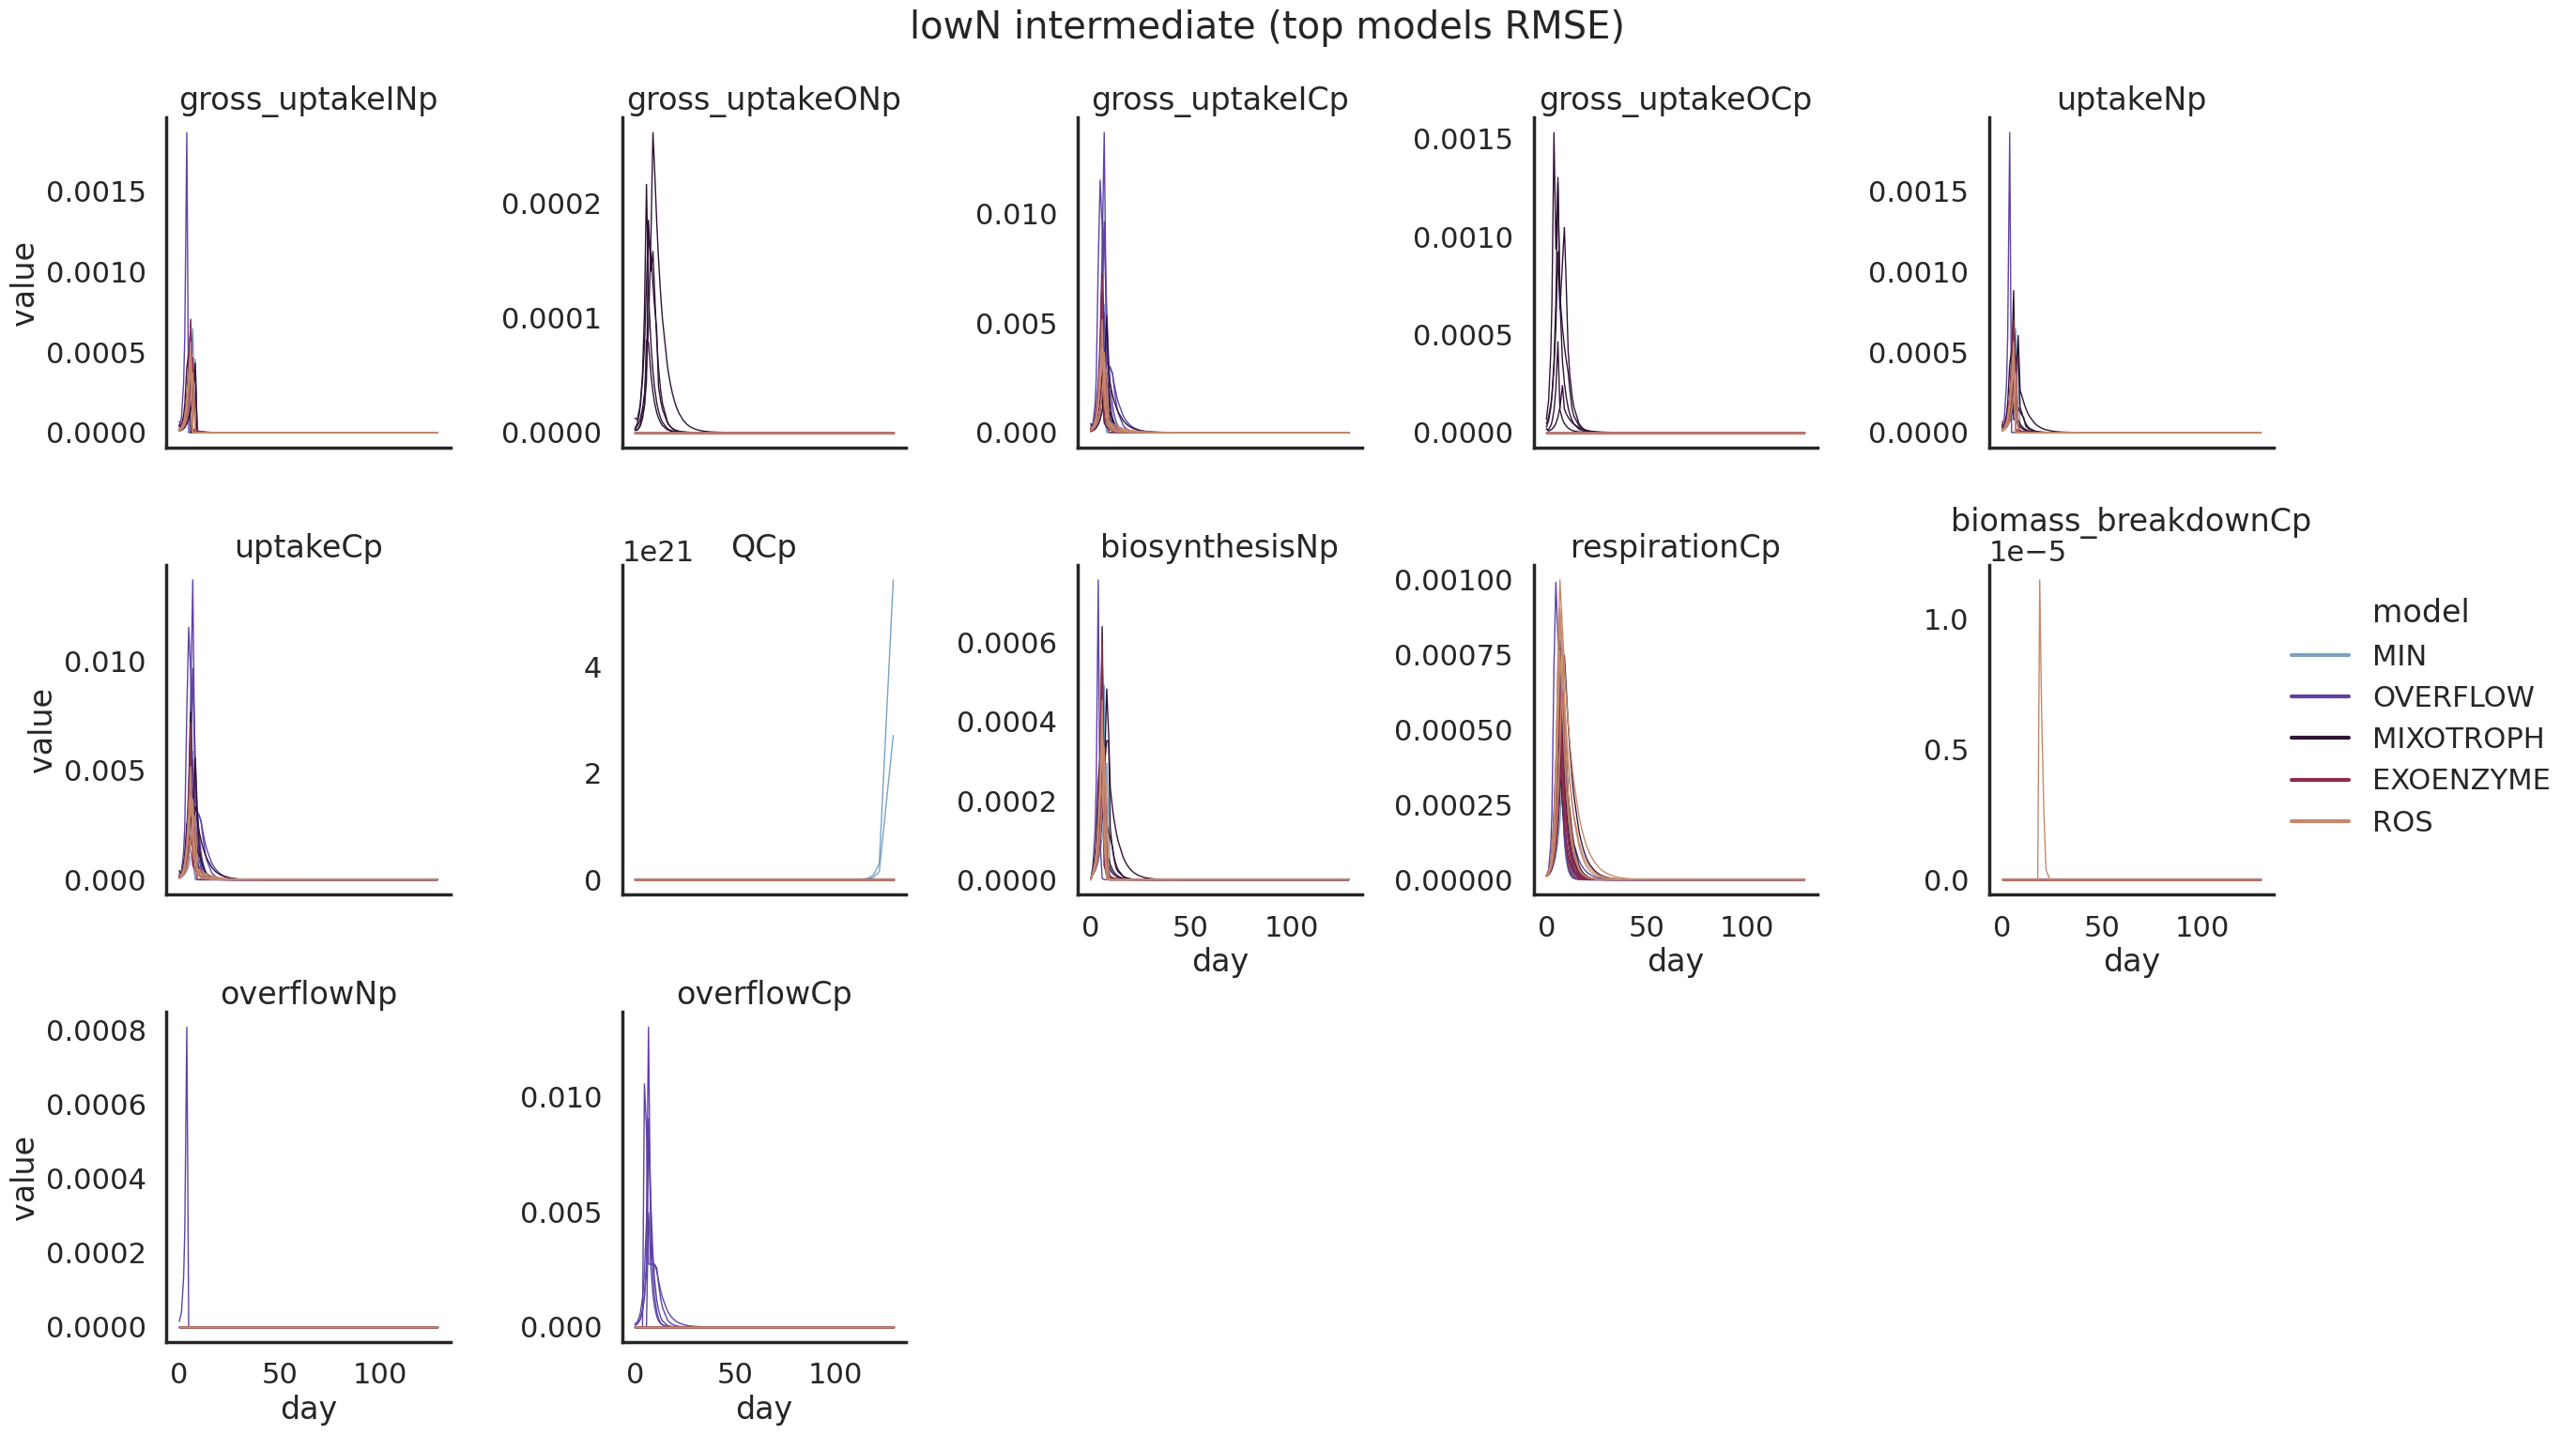

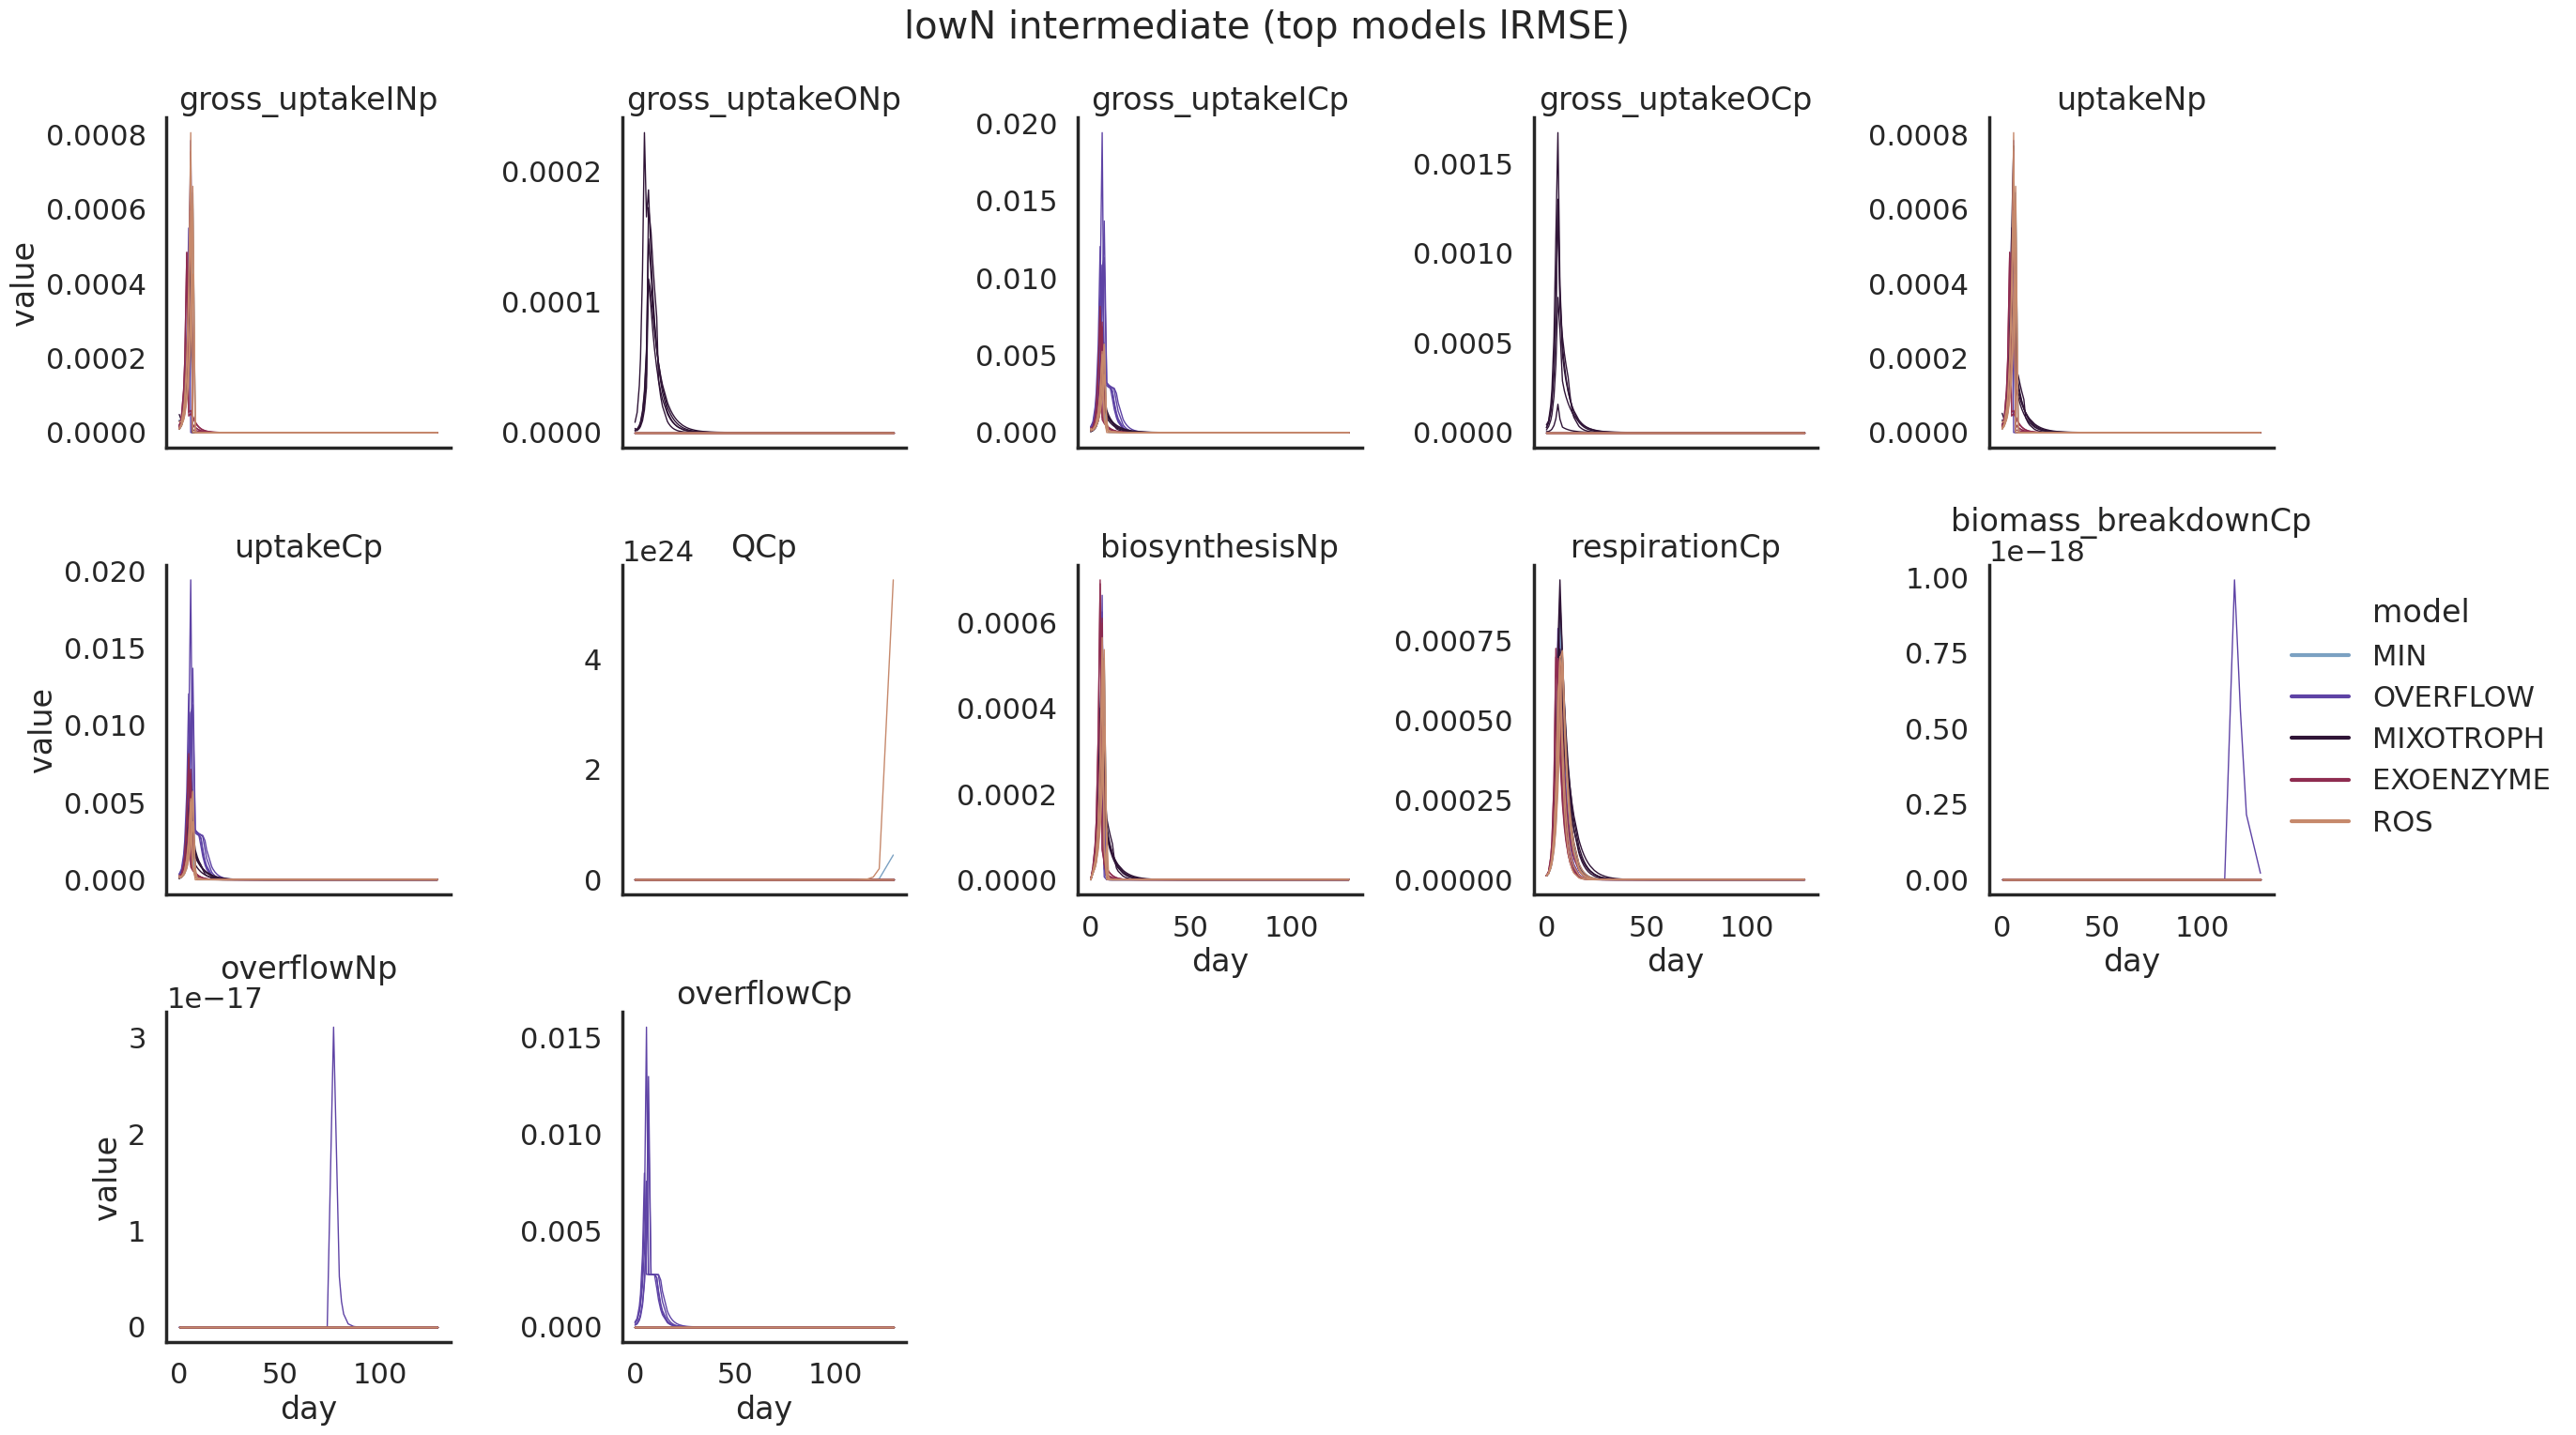

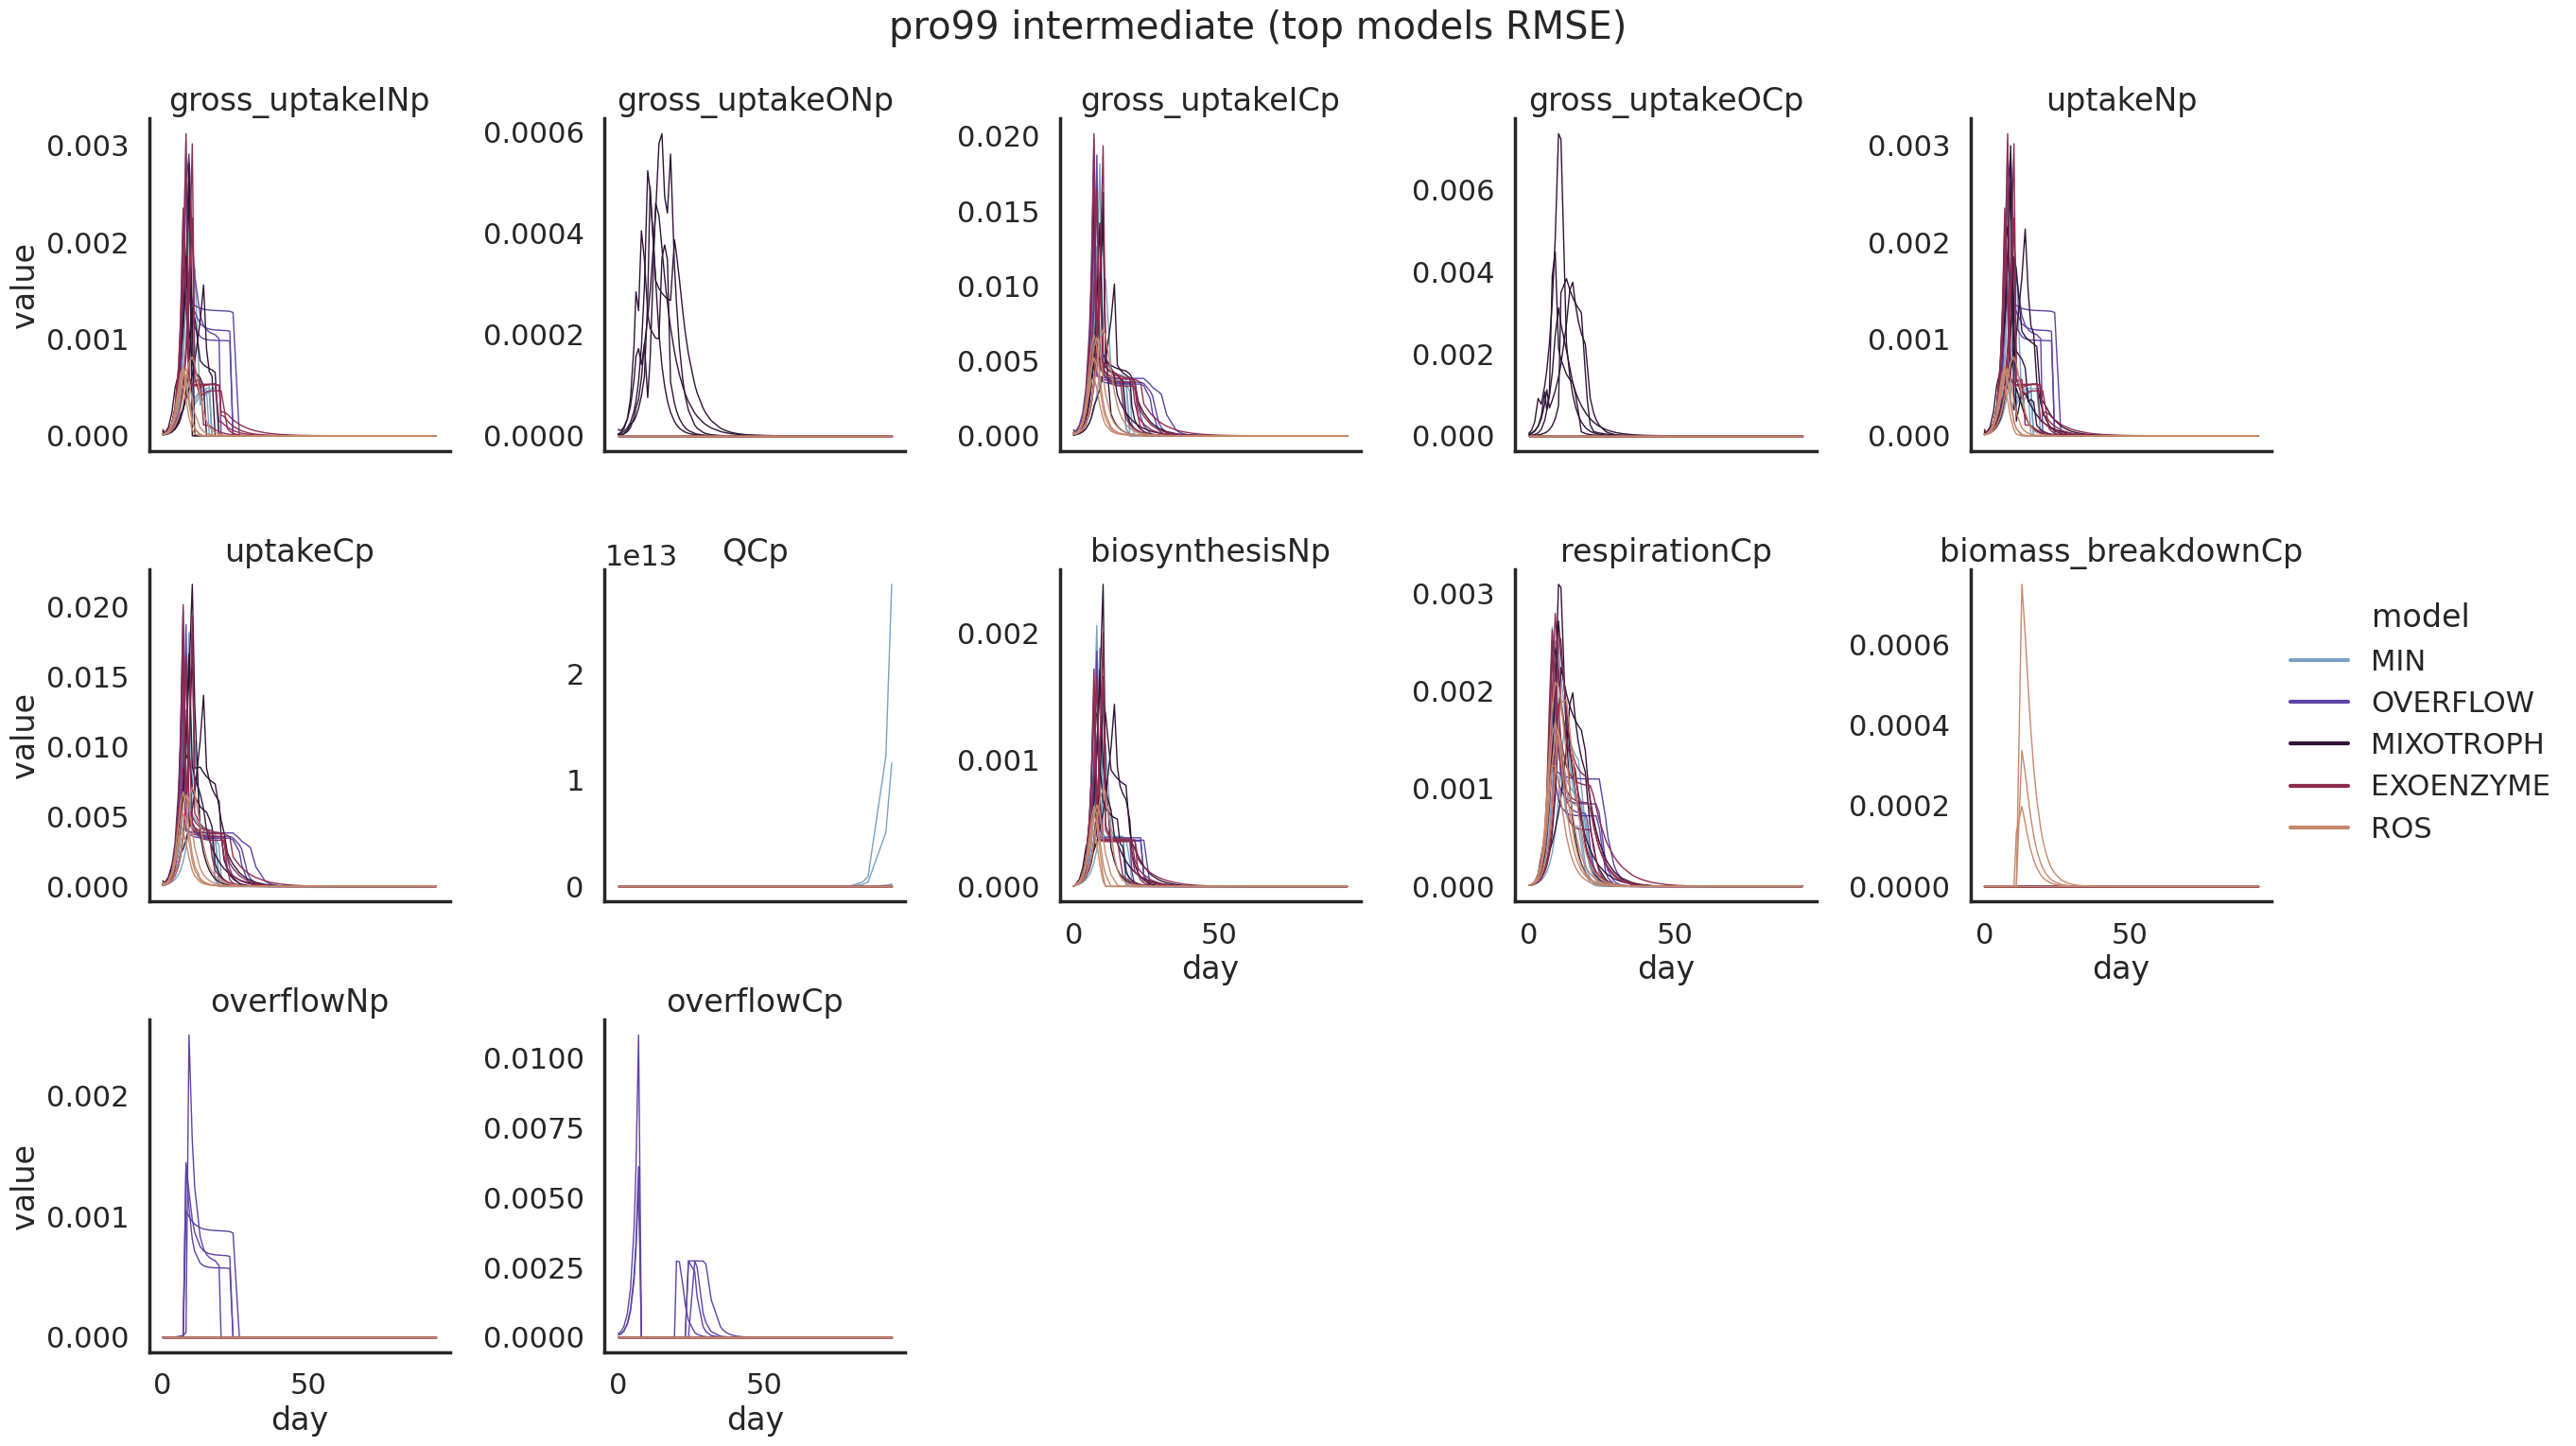

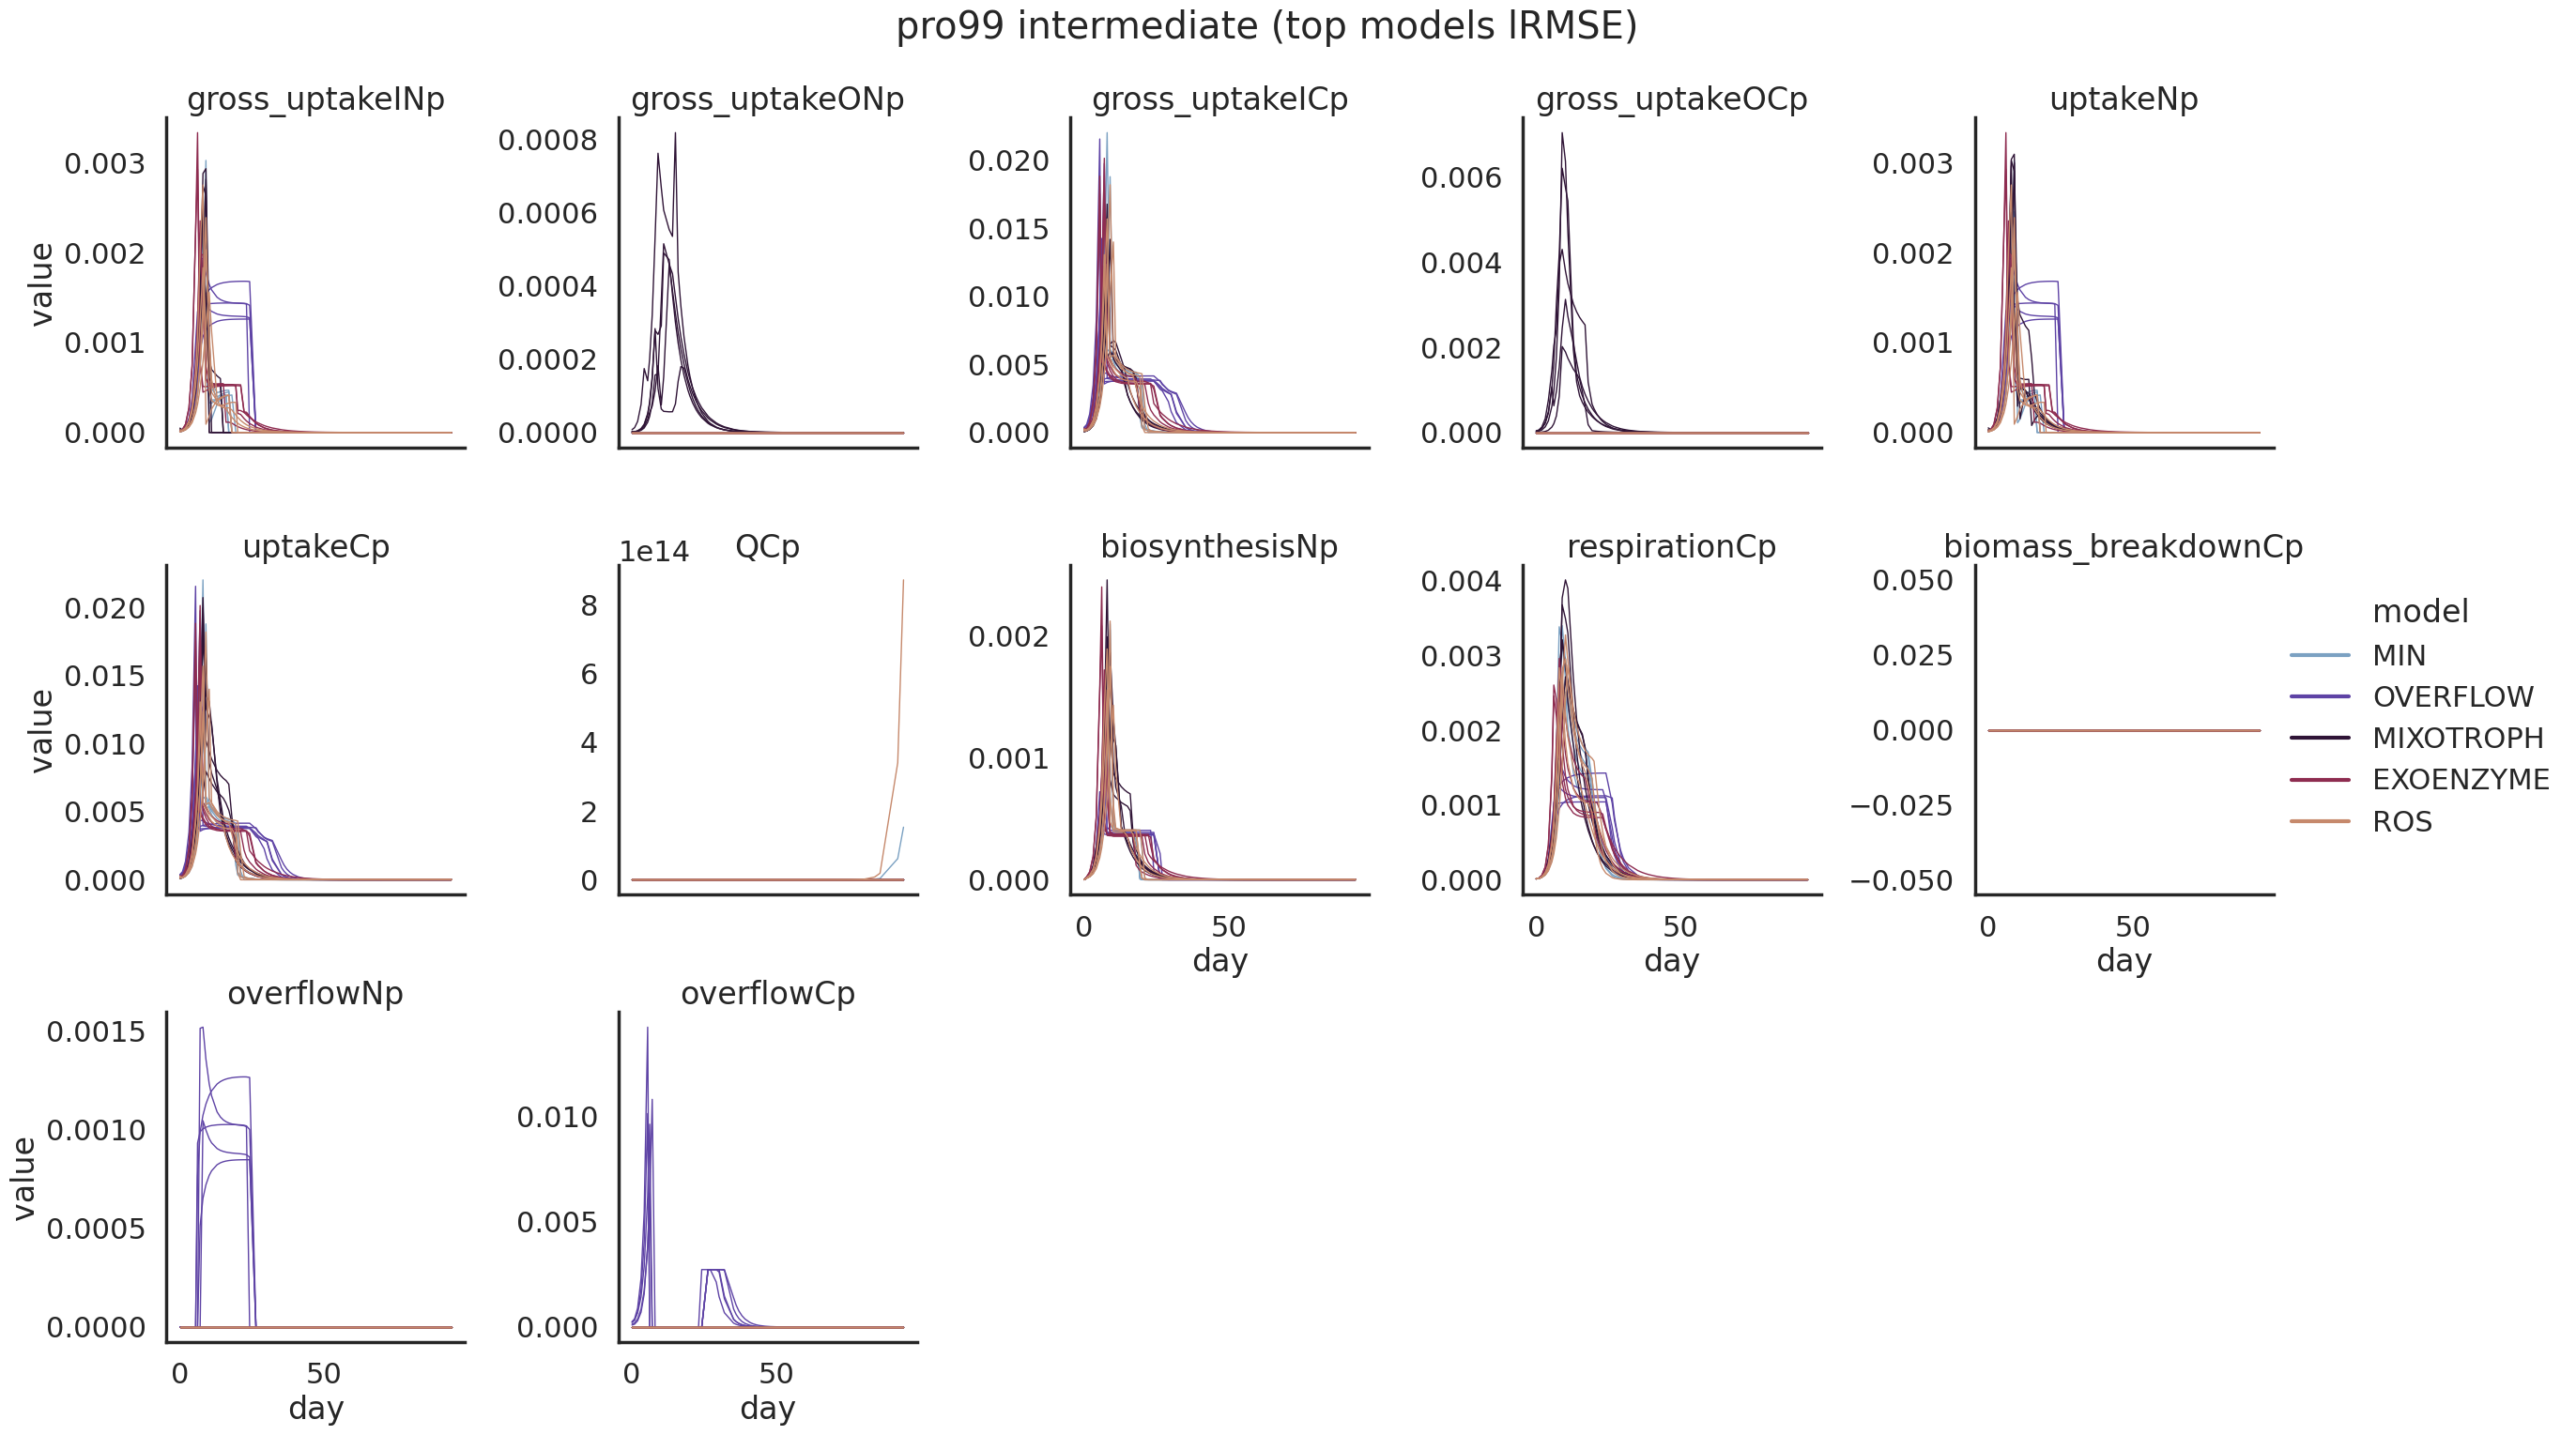

In [93]:
for med in media_order:
    for l in ('RMSE', 'lRMSE'):
        rankcol = 'rank' if l == 'RMSE' else 'lrank'
        mrows = mean_scores.loc[mean_scores[rankcol].le(5)]

        g = sns.relplot(
            data=mdf2.loc[mdf2.idx.isin(mrows.idx) & mdf2.media.isin([med])],
            kind='line', 
            estimator=None, units='idx',
            x='day', y='value', 
            col='variable', lw=1, col_wrap=5,
            hue='model', hue_order=morder, palette=mpalette,
            facet_kws=dict( margin_titles=True, sharey=False),

        )
        g.set_titles(col_template='{col_name}', row_template='{row_name}')
        plt.suptitle(f'{med} intermediate (top models {l})', y=1.03)

In [ ]:
for med in media_order:
    for l in ('RMSE', 'lRMSE'):
        mrows = min_rows if l == 'RMSE' else lmin_rows

        g = sns.relplot(
            data=mdf1.loc[mdf1.idx.isin(mrows.idx) & mdf1.media.isin(['lowN'])],
            kind='line', 
            estimator=None, units='idx',
            x='day', y='value', 
            col='variable', lw=1, col_wrap=5,
            hue='model', hue_order=morder, palette=mpalette,
            facet_kws=dict( margin_titles=True, sharey=False),

        )
        g.set_titles(col_template='{col_name}', row_template='{row_name}')
        plt.suptitle(f'{med} simulation results (top models {l})', y=1.03)

In [ ]:
min_rows.columns

In [ ]:
def write_json(x):
    fpath = os.path.join(dpath,f"pro_x0_{x['model']}_{x['rank']:g}.json")
    x = x.dropna()
    x= x.drop(['SSE', 'model',  'RMSE', 'error_bin', 'rank'])
    d = x.to_dict()
    params2json(d, fpath)
    print(fpath, d)

min_rows.apply(write_json, axis=1)
    